# Import libraries

In [1]:
# Set a jupyter notebook coding container to fit the borders of a web browser.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Data structures
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Data Preparations
import re 
from sklearn.model_selection import train_test_split

# Tuning best parameters
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Filtering outliers
from sklearn.ensemble import IsolationForest

# Statistics
import math
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols

# Ploting
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Do not need to call plt.show() when ploting a graph
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # add plot figure back line

import seaborn as sns
sns.set()

In [3]:
# Word sentiment anylysis
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

# Data Preparations 
from bs4 import BeautifulSoup

# Tokenization
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Models
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransform

# Data visualizaiton
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /Users/alicis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alicis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alicis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Global variables

In [4]:
# The List of the names that represent the missing values
missing_values = ["n/a", "na", "--"]

# Data Preparation functions
The functions that perform data preparation or data cleansing

In [5]:
def drop_unbalanced_ratio(df):
    """ 
    Drop column that has an unbalanced unique value ratio (one unique value or excessive unique values).
    
    Notes:
    - One unique value or too many unique values columns doesn't give a decent analysis 
    because it doesn't give meaningful information.
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    data: The dataframe that dropped column that has one unique value or excessive unique values.
    
    """
    
    data = df.copy()
    
    print("\nDropped unbalanced ratio columns...")
    
    # Drop the columns that contain one unique value or 
    # Drop the column that has unique variables equal to the number of values. (Too many unqiue values inside)
    for col_name in data.columns:
        if data[col_name].count() == len(data[col_name].unique()) or len(data[col_name].unique()) == 1:
            print (col_name)
            data.drop(col_name, axis=1,inplace = True)

    return data



def string2bool(df):
    """ 
    Convert the columns that has likely boolean string to boolean type.
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    merged_df: The dataframe after converted column that has likely boolean string to boolean.
    
    """
    
    # Select the categorical columns
    non_num_feats = df.select_dtypes(exclude=['number','bool']).copy()
    # Select the numeric columns
    num_feats = df.select_dtypes(include='number').copy()

    print ("\nConverted boolean string to boolean type...")

    for col_name in non_num_feats.columns:
        # Get a serie from the numeric column name
        tmp_serie = non_num_feats[col_name].dropna()
        # Get the unique value names from above serie
        unique_set = set(tmp_serie.value_counts().index.str.lower())
        # Map likely boolean string to boolean if each set equal
        if unique_set == {'t','f'}:
            non_num_feats.loc[:, col_name] = non_num_feats.loc[:, col_name].map({'t': True, 'f': False})
            print (col_name)
        elif unique_set == {'true','false'}:
            non_num_feats.loc[:, col_name] = non_num_feats.loc[:, col_name].map({'true': True, 'false': False})
            print (col_name)

    # Combine numeric_features and non_num_features together
    merged_df = pd.concat([non_num_feats, num_feats], axis=1)
    
    return merged_df

def remove_spl_char(df):
    """ 
    Remove special characters.
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    data: The removed special characters dataframe.
    
    """
    
    print("\nRemoving special character...")
    
    data = df.copy()
    # Regex: The string must contain at least one ,.$% and contain only 0-9,.$%
    pattern = re.compile("^(?=^[0-9,.$%]+$)(?=.*?[,.$%]).+$")
    for col_name in data.columns:
        if data[col_name].dtype == "object":
            # Replace the text that contains only special character to missing value (np.nan)
            data[col_name].replace(r"^[^A-Za-z0-9]+$", np.nan, regex=True, inplace=True)
            if data[col_name].str.match(pattern).all():
                # Replace the texts that don't contain contain A-Za-z0-9. characters
                data[col_name].replace(r"[^A-Za-z0-9.]+", "", regex=True, inplace=True)
                # Convert the numeric string to numeric dtype
                data[col_name] = pd.to_numeric(data[col_name])
                # Show the column names that removed special characters
                print(col_name)
            else:
                # Replace the texts that don't contain A-Za-z0-9 ^,!?.\/ characters 
                data[col_name].replace(r"[^A-Za-z0-9 ^,!?.\/'+]", "", regex=True, inplace=True)
                    
    return data

# Filtering outlier functions

In [6]:
def z_outlier_filter(df):
    """ 
    Filter outlier by statistic z score.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values.
    
    Returns:
    filtered_df: The removed outlier dataframe by using statistic z score.
    
    """
    data = df.copy()
    
    # Calculate z-scores
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    
    # Replace missing value (NaN) to 0
    abs_z_scores[np.isnan(abs_z_scores)] = 0
    
    # Select the columns that have absolute z-scores < 3
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    filtered_df = data[filtered_entries]
    return filtered_df

def ML_outlier_filter(df):
    """ 
    Filter outlier by Isolation Forest
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values and not contain any missing values.
    
    Returns:
    anomaly_solved: The removed outlier dataframe by using machine learning (isolationForest).
    
    """
    data = df.copy()
    # Define classifier
    clf = IsolationForest(max_samples=100, random_state = 42, contamination= 'auto')
    data['anomaly'] = clf.fit_predict(data)
    
    # Select the normal datapoints
    anomaly_solved = data[data['anomaly'] == 1]
    anomaly_solved = anomaly_solved.drop('anomaly',axis=1)
    return anomaly_solved

# Find the best parameters function

In [7]:
def rf_best_para(features, label, cross_v):
    """ 
    Find the best random forest parameters
    
    Notes:
    If categorical data is inside your features, you must convert to one-hot encoding or numeric before assign that feature.
    
    Args:
    features: dataframe. The features pandas dataframe.
    label: dataframe series. The target series.
    cross_v: int, The number of cross validation fold.
    
    Returns:
    rf_random: The RandomForest model with optimized parameters.
    
    """
    # Define randomforest hyperparameters
    # Create the grid parameters
    param_grid = {'n_estimators': [100,150,200,300], # Number of trees in random forest
                  'max_features': ['auto','sqrt'], # Number of features to consider at every split
                  'max_depth': [18,20,22], # Maximum number of levels in tree
                  'min_samples_split': [1,3,5], # Minimum number of samples required to split a node
                  'min_samples_leaf': [1,2,3], # Minimum number of samples required at each leaf node
                  'bootstrap': [True, False], # True: Bootstrap samples are used when building trees False: The whole dataset is used to build each tree
                  'random_state': [42]} # Method of selecting samples for training each tree
    
    # Switch between classifier and Regressor according to target dtype
    if label.dtype == 'object':
        rf = RandomForestClassifier()
    else:
        rf = RandomForestRegressor()

    # Perform the gridsearch and cross-validation to search for best hyperparameters
    optimized_rf = GridSearchCV(estimator = rf, param_grid=param_grid, cv = cross_v, verbose=2, n_jobs = -1)
    # Fit data to the opimize rf model
    optimized_rf.fit(features, label)
    # Show optimized RandaomForest best parameters
    print(optimized_rf.best_params_)
    
    return optimized_rf

# Feature selection functions

In [8]:
def remove_high_corr(df, threshold = 0.75):
    """ 
    Remove high correlation features/columns.
    
    Args:
    df: dataframe. the pandas dataframe.
    threshold: float. The correlation threshold that used to drop the high correlation columns.
    
    Returns:
    removed_high_corr: The dataframe after removed high correlation features.
    
    """    
    
    # Separate numeric and non-numeric columns/features
    numeric_feats = df.select_dtypes(include='number').copy()
    non_num_feats = df.select_dtypes(exclude='number').copy()
    
    # Intialize the correlations
    corr = numeric_feats.corr()
    # To make sure while loop does not perform infinite loops when problems occur.
    j=0
    print ('Dropped high correlation column... ')
    # In each while loop, drop the features that have a high correlation (set by threshold) with others.
    # Then drop features again until all features don't have high correlation with other features
    while (j < len(numeric_feats.columns)):
        # Loop for each feature correlation
        for corr_col in corr.columns:
            # the not drop count (total not-drop activities)
            not_drop = 0
            corr_len = len(corr.columns)
            # Get the feature correlation list 
            corr = numeric_feats.corr()
            corr_target = abs(corr.loc[:,corr_col])
            # Select the features that have correlation > threshold
            relevant_features = corr_target[corr_target>threshold]
            # Drop itself
            relevant_features.drop(labels=corr_col, inplace=True)
            
            # If correlation > threshold features exist then...
            if relevant_features.index.values.shape[0] > 0:
                # Drop the features that have correlation > threshold
                numeric_feats.drop(relevant_features.index.values,axis=1, inplace=True)
                # Show the dropped features
                print (relevant_features.index.values)
            # The feature correlations after dropped or not drop features
            update_corr = numeric_feats.corr()
            # If the dropping of the correlation > threshold features occur then break the inner loop and calculate correlation again after break (inside new for loop)
            if len(update_corr.columns) != corr_len:
                break
            not_drop +=1
        # Break outter loop if features that correlation > threshold aren't dropped
        if not_drop == corr_len:
            break
        j+=1
        
    # Combine the numeric features and catergorical features
    non_num_feats_df = pd.DataFrame(non_num_feats,index = numeric_feats.index)
    merged_feats = pd.concat([non_num_feats_df, numeric_feats], axis=1)
    
    # Drop the features that has an unbalanced unique value ratio
    removed_high_corr = drop_unbalanced_ratio(merged_feats)
    
    # Reset index after drop the features
    removed_high_corr.reset_index(drop=True, inplace=True)
    
    return removed_high_corr

def rf_feat_importances(optimized_model):
    """ 
    Plot the feature importances bar chart for visualization.
    
    Args:
    optimized_model: model. The model after optimized hyperparameters
    
    Returns:
    feat_importances: The series of feature names and their importances in percentage.
    
    """
    
    # Plot the feature importances bar chart for visualization
    feat_importances = pd.Series(optimized_model.best_estimator_.feature_importances_, index=X.columns)
    feat_importances.nlargest(16).plot(kind='barh',figsize=(20,10))
    plt.show()
    
    print ('Top 20 Selected features:\n', feat_importances.nlargest(20))
    
    return feat_importances

def feature_selection(df, feature_importances, threshold = 0.99):
    """ 
    Perform feature selection by accumulating(descending) the importance of features until the importance number meets the threshold.
    The features that are not in the accumulation, are dropped.
    
    Args:
    df: dataframe. The pandas dataframe that contains only features and exclude target.
    feature_importances: dictionary. The dictionary of feature names and their importances in percentage.
    threshold: float. The accumulating threshold in percentage.
    
    Returns:
    selected_features: The selected feature dataframe.
    
    """
    features = df.copy()
    # Sort the feature importances by descending to perform descending accumulation
    feat_importances = feature_importances.sort_values(ascending = False).copy()
    col_name = pd.DataFrame(columns = ['name'])
    # The accumulated importances
    importances = 0
    for idx in range(len(feat_importances)):
        # Accumulate importance value(percentage)
        importances += feat_importances[idx]
        # Store accumulated feature column name
        col_name.loc[idx] = feat_importances.index[idx]
        if importances >= threshold:
            break
    # Select the accumulated features
    selected_features = features[col_name['name']]
    
    return selected_features

# Data visualization functions 

In [9]:
def rf_evaluate(model, test_features, test_labels):
    """ 
    Evaluate model by calculating accuracy from square mean errors (SME).
    
    Args:
    model: object. The model object.
    test_features: dataframe. The feature pandas dataframe.
    test_labels: dataframe. The label/target pandas dataframe.
    
    Returns:
    accuracy: The model accuracy.
    
    """
    # Predict the model
    predictions = model.predict(test_features)
    # Calculate error
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    # Calculate accuracy
    accuracy = 100 - mape
    
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

def plot_pearson_corrs(df, size_x = 10, size_y = 7):
    """ 
    Plot Pearson's correlations
    
    Args:
    df: dataframe. The feature pandas dataframe.
    size_x: float. x axis size.
    size_y: float. y axis size.
    
    """
    # Set the size of axi
    plt.figure(figsize=(size_x,size_y))
    # Get Pearson correlation coefficient 
    cor = df.corr()
    # Plot heatmap
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show
    
def plot_corr(df, feature, target, size_x=5, size_y=4):
    """ 
    Plot Pearson's correlation in pair.
    
    Args:
    df: dataframe. The pandas dataframe.
    feature: dataframe serie. The numeric feature pandas serie.
    target: dataframe serie. The numeric target pandas serie.
    size_x: float. x axis size.
    size_y: float. y axis size.
    
    """
    data = df[[feature, target]].copy()
    corr = data.corr()
    plt.figure(figsize=(size_x, size_y))
    sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
    plt.show()
    

def plot_scatter(df, feature, target, size_x=5, size_y=4, s=10):
    """ 
    Plot scatter plot in pair.
    
    Args:
    df: dataframe. The pandas dataframe.
    feature: dataframe serie. The numeric feature pandas serie.
    target: dataframe serie. The numeric target pandas serie.
    size_x: float. x axis size.
    size_y: float. y axis size.
    s: float. a marker size.
    
    """
    data = df[[feature, target]].copy()
    
    plt.figure(figsize=(size_x, size_y))
    plt.scatter(filtered_features[target],filtered_features[feature], s=s)
    plt.show()    
    
def plot_swarmbox(df, feature, target, size_x=8, size_y=6, s=4.5):
    """ 
    Plot the data by using boxplot and swarmplot.
    
    Args:
    df: dataframe. The pandas dataframe.
    feature: dataframe serie. The categorical or discrete feature pandas serie.
    target: dataframe serie. The numeric target pandas serie.
    size_x: float. x axis size.
    size_y: float. y axis size.
    s: float. a marker size.
    
    """
    plt.figure(figsize=(size_x, size_y))
    ax = sns.swarmplot(x=feature, y=target, data=df, s=s)
    ax = sns.boxplot(x=feature, y=target, data=df, color='white', linewidth=s-1.5)
    plt.show()

# Loading datasets


## Boston dataset

In [10]:
# Load Boston data
raw_boston_data = pd.read_csv("datasets/boston/listings.csv", na_values = missing_values)

## Seattle dataset

In [11]:
# Load Seattle data
raw_seattle_data = pd.read_csv("datasets/seattle/listings.csv", na_values = missing_values)

# The 1st question : What factors affect price fluctuations?
I will predict the price (target) to find what factors affect price fluctuation?

# 1. Data preparation
- Begin the data preparation or data cleansing

## 1.1 Drop unused features
- Drop the features that are not good in predictions. <br>
- The reasons why i drop these features are in the comment above the list of dropped columns/features.

In [12]:
             # Require NLP to interpret (Out of quesiton scope)
drop_cols = ['name','summary','space','description','neighborhood_overview','notes','transit','access','interaction',
             'house_rules','host_about',# Require NLP to interpret (Out of quesiton scope)
             # Doesn't provide meaningful information.
             'host_name',
             # Unbalanced unique values (one unqiue value dominates other unique value in the number)
             # Unbalanced unique values don't give meaningful information to analysis
             'street', 'city','host_location', 'smart_location','host_acceptance_rate', 'host_response_rate', 'market',
             'availability_30','availability_60','availability_90','availability_365',
             'host_listings_count', 'host_total_listings_count','calculated_host_listings_count','minimum_nights','maximum_nights',
             # Duplicate with neighbourhood_cleansed
             'neighbourhood',
             # Decrease the model accuarcy and also has many NaN values.
             'host_verifications', 'host_response_time', 'host_neighbourhood', 'amenities',
             # Have directly relationships with price (same currency $ dollars)
             'cleaning_fee','extra_people','security_deposit','guests_included',
             # Have directly relationships with price (when price increase these value increase without causation)
             'accommodates','beds','bedrooms','bathrooms',
             # I will not use these dates features to analyse (past related values)
             'calendar_updated','host_since','first_review','last_review',
             # Have high relations with other undrop review score features
             'review_scores_rating','review_scores_value','number_of_reviews','reviews_per_month','review_scores_accuracy']
             # Filter out uninterpretable ID and URL columns
boston_data = raw_boston_data.loc[:, ~raw_boston_data.columns.str.contains('id|url')].drop(drop_cols, axis=1).copy()
# Show the dropped columns
print ('Dropped url and id columns: ')
print (raw_boston_data.loc[:, raw_boston_data.columns.str.contains('id|url')].columns.values)

Dropped url and id columns: 
['id' 'listing_url' 'scrape_id' 'thumbnail_url' 'medium_url' 'picture_url'
 'xl_picture_url' 'host_id' 'host_url' 'host_thumbnail_url'
 'host_picture_url' 'host_identity_verified']


## 1.2 Drop columns that has an unbalanced unique value ratio
- Drop the columns that have an unbalanced unique value ratio (one unique value or excessive unique values).
<br> Note: One unique value or too many unique values inside the columns doesn't give a good analysis because they doesn't give meaningful information.

In [13]:
# Drop the column that has an unbalanced unique value ratio
unique_filtered = drop_unbalanced_ratio(boston_data)


Dropped unbalanced ratio columns...
last_scraped
experiences_offered
neighbourhood_group_cleansed
state
country_code
country
latitude
longitude
has_availability
calendar_last_scraped
requires_license
license
jurisdiction_names


## 1.3 Transform boolean string to boolean type

In [14]:
# Transform boolean string to boolean type
cleaned_bool= string2bool(unique_filtered)


Converted boolean string to boolean type...
host_is_superhost
host_has_profile_pic
is_location_exact
instant_bookable
require_guest_profile_picture
require_guest_phone_verification


## 1.4 Remove special character

In [15]:
# Remove special characters in DataFrame
removed_spl = remove_spl_char(cleaned_bool)


Removing special character...
price
weekly_price
monthly_price


## 1.5 Drop missing values (NaN)
- To set missing values threshold, set nan_threshold to 0.75: 1-0.75=0.25->25%, if you want drop the columns that has missing value more than 25%. Because we calculate nan_thershold from missing value mean.

In [16]:
nan_threshold = 0.75
# Drop the columns that has missing values more than the missing value threshold
mis_columns = removed_spl.columns[removed_spl.isnull().mean()>nan_threshold]
removed_spl.drop(mis_columns, axis=1, inplace=True)

print('Dropped columns that contains missing value > ', (1-nan_threshold)*100,'%: ')
print(list(mis_columns))

Dropped columns that contains missing value >  25.0 %: 
['weekly_price', 'monthly_price', 'square_feet']


### 1.5.1 Drop missing values (NaN) in the target column

In [17]:
# Drop missing values (NaN) in label/target column
standard_cleaned_df = removed_spl.dropna(subset=['price'],axis=0).copy()

# Reset index after dropped the rows contain missing values
standard_cleaned_df.reset_index(drop=True, inplace=True)
standard_cleaned_df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,zipcode,is_location_exact,property_type,room_type,bed_type,price,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
0,False,True,Roslindale,02131,True,House,Entire home/apt,Real Bed,250.0,False,moderate,False,False,NaN,NaN,NaN,NaN
1,False,True,Roslindale,02131,True,Apartment,Private room,Real Bed,65.0,True,moderate,False,False,9.0,10.0,10.0,9.0
2,True,True,Roslindale,02131,True,Apartment,Private room,Real Bed,65.0,False,moderate,True,False,9.0,10.0,10.0,9.0
3,False,True,Roslindale,NaN,False,House,Private room,Real Bed,75.0,False,moderate,False,False,10.0,10.0,10.0,10.0
4,True,True,Roslindale,02131,True,House,Private room,Real Bed,79.0,False,flexible,False,False,10.0,10.0,10.0,9.0


### 1.5.2 Drop missing values (NaN) before removed outliner
- Because isolate forest machine learning technique can't hanndle NaN.

In [18]:
# Drop the rows that contain missing values 
standard_cleaned_df.dropna(axis=0, inplace=True)
# Reset index after dropped the rows that contain missing values
standard_cleaned_df.reset_index(drop=True, inplace=True)

## 1.6 Remove outliers
An outlier is a crucial problem that makes our model inaccurate and inefficient. we should handle it before performing any actor that relates to machine learning or modeling.

### 1.6.1 Separate numeric and non-numeric columns/features
- Because we only remove outiler for numeric type

In [19]:
# Separate numeric and non-numeric features
numeric_feats = standard_cleaned_df.select_dtypes(include='number')
non_num_feats = standard_cleaned_df.select_dtypes(exclude='number')

### 1.6.2 The statistic z-score
- Filter outliner by statistic z score.

In [20]:
# Remove outliers by statistic z-score method
z_anomaly_solved = z_outlier_filter(numeric_feats)

### 1.6.3 Isolation Forest
- Isolation Forest is an outlier detection technique that identifies anomalies instead of normal observations
- The Isolation Forest isolate observations into abnormal vs normal observations by the following step:
<br><img src="images/Isolation_forest_pic.png" align="left"/>

- At each node in the decision tree, randomly select a feature then selecting a splitting value between maximum and minimum values of the selected feature/column to split the dataset into two.
- After that, keep doing the above step until all observations are isolated from each other.
- The anomalies are detected by finding the observation that is isolated faster or easier than other observations because the anomalies are normally far from normal observations.

In [21]:
# Remove outliers by manchine learning method
anomaly_solved = ML_outlier_filter(z_anomaly_solved)

### 1.6.4 Drop columns that have an unbalanced unique value ratio. Then merge numeric and categorical columns

In [22]:
# Drop the columns that has an unbalanced unique value ratio after removed outliers
anomaly_solved = drop_unbalanced_ratio(anomaly_solved)
    
# Combine numeric features and catergorical features
non_num_feats_df = pd.DataFrame(non_num_feats,index = anomaly_solved.index)
removed_outlier = pd.concat([non_num_feats_df, anomaly_solved], axis=1)

# Reset index after dropped the rows that contain missing values
removed_outlier.reset_index(drop=True, inplace=True)
removed_outlier.shape


Dropped unbalanced ratio columns...


(1559, 17)

# 2. Feature selection
- The process that searching and selecting the most useful features in the dataset and discard unnecessary features. 
- The feature selection step is an important step in data preparation because it ditches the unimportant features that decrease training speed, accuracy and interpretation of the model.
#### Due to the high number of features, i need to perform automatic features selection fucntions.

## 2.1 Pearson's correlation
Pearson correlation is the relationship between the two numeric variables. A relationship value or correlation can interpret as follows in the range of -1 to 1.
<br> Calculate correlations or relationships between columns then drop the high correlation columns by using a correlation threshold.
- Correlation > 0; There is a positive relationship.
- Correlation < 0; There is a negative relationship.
- Correlation = 0; There isn't a relationship.

We can also use the heat map to provides a clear picture of the correlation between the columns as in the figure above. The correlation heat map can be interpreted as follow.
- The darker colour the greater the correlation value.
- The lighter colour the less the correlation value.

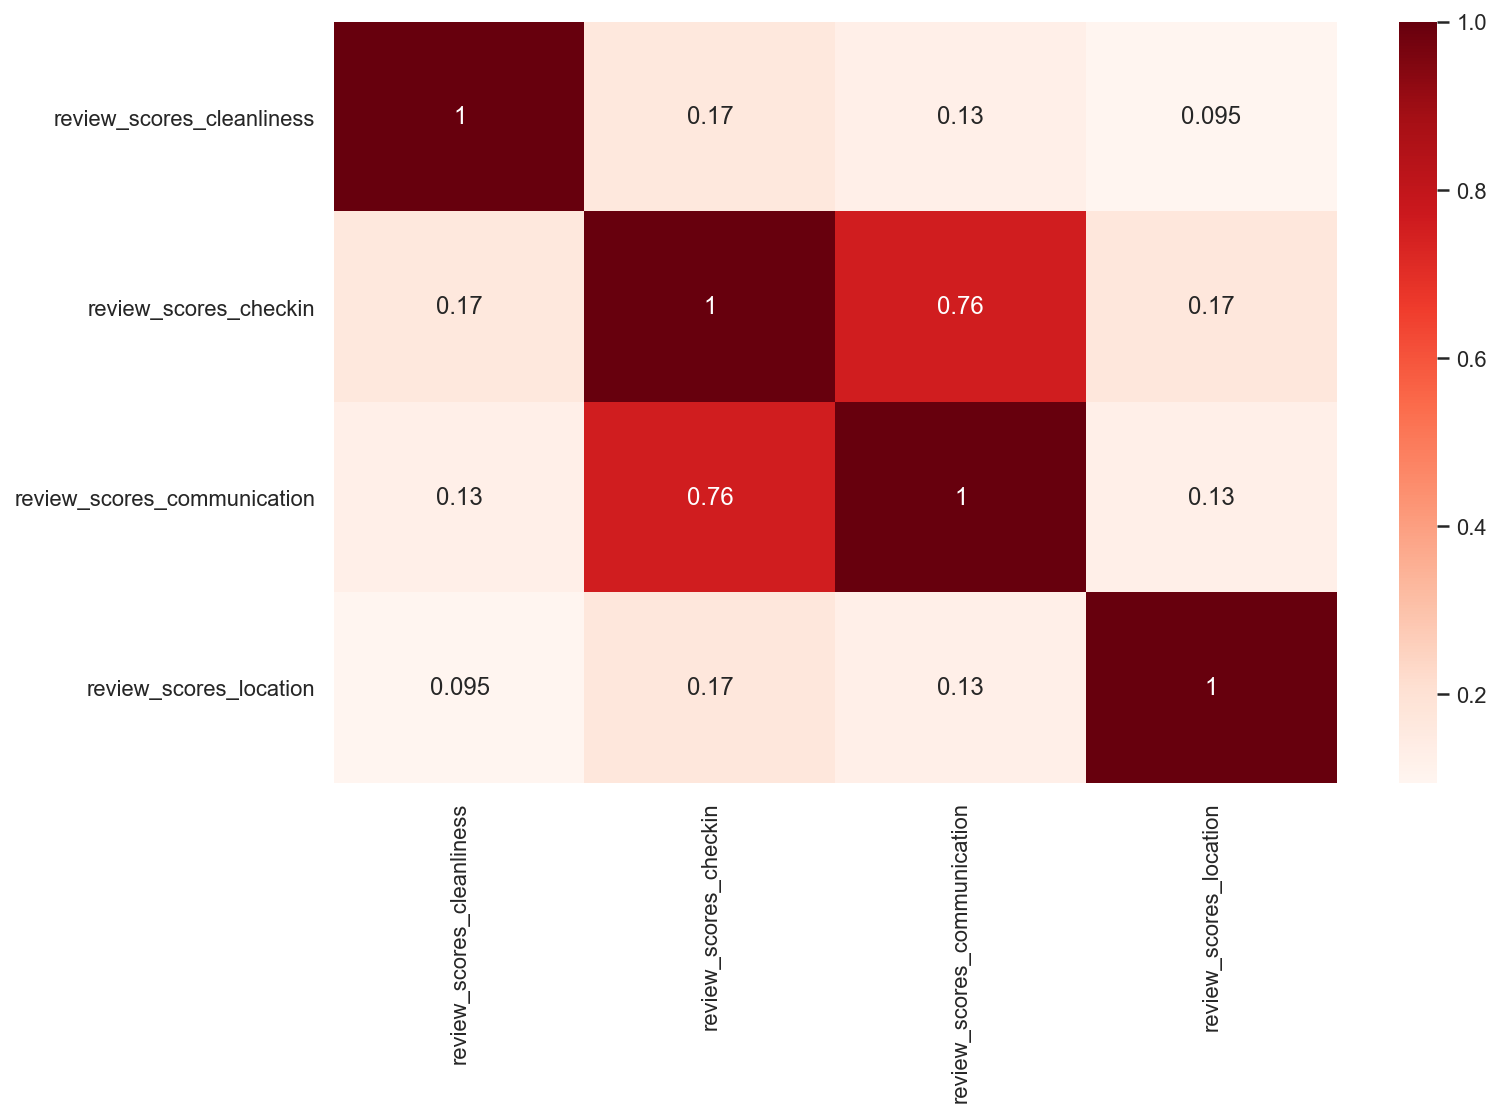

In [23]:
# Show column correlations for numeric valuesWe can drop the high correlation columns because
plot_pearson_corrs(removed_outlier.select_dtypes(include='number').drop('price',axis=1))

### 2.2.1 Drop high correlation features by Pearson's correlation
#### The threshold is ranged between 0 and 1 because it is an absolute of relationship value.

We can drop high correlation columns because:
- The column that has a high relationship with other columns, can represent each other. Therefore we can just keep one of them. <br> 

In [24]:
# Remove high correlation features
filtered_features = remove_high_corr(removed_outlier, 0.75)
filtered_features.shape

Dropped high correlation column... 
['review_scores_communication']

Dropped unbalanced ratio columns...


(1559, 16)

## 2.3 Random Forest
- Random Forest machine learning is a combination of multiple different decision trees that vote for the best result.
- A decision tree is a diagram that is used to determine a the decision making.
<br><img src="images/random_forest_pic.png" align="left"/>

### 2.3.1 Create dummies for categorical values
- If categorical values present in your dataframe before put that values in the machine learning, you must convert to numeric value or one-hot encoding before assign that dataframe.

In [25]:
# Select features by drop the target column
X_features = filtered_features.drop('price', axis = 1)

# Add dummies to DataFrame by put in categorical values
dummies_data = pd.get_dummies(X_features, prefix_sep='_', dummy_na=False)
# Remove space ' ' and place it with '_' to make column names easiler to analyse.
dummies_data.columns = dummies_data.columns.str.replace(' ', '_')
dummies_data.head()

,host_is_superhost,host_has_profile_pic,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,review_scores_cleanliness,review_scores_checkin,review_scores_location,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back_Bay,neighbourhood_cleansed_Bay_Village,neighbourhood_cleansed_Beacon_Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East_Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde_Park,neighbourhood_cleansed_Jamaica_Plain,neighbourhood_cleansed_Leather_District,neighbourhood_cleansed_Longwood_Medical_Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission_Hill,neighbourhood_cleansed_North_End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South_Boston,neighbourhood_cleansed_South_Boston_Waterfront,neighbourhood_cleansed_South_End,neighbourhood_cleansed_West_End,neighbourhood_cleansed_West_Roxbury,zipcode_02108,zipcode_02108_02111,zipcode_02109,zipcode_02110,zipcode_02111,zipcode_02113,zipcode_02114,zipcode_02115,zipcode_02116,zipcode_02118,zipcode_02119,zipcode_02120,zipcode_02121,zipcode_02122,zipcode_02124,zipcode_02125,zipcode_02126,zipcode_02127,zipcode_02128,zipcode_02129,zipcode_02130,zipcode_02131,zipcode_02132,zipcode_02134,zipcode_02135,zipcode_02136,zipcode_02138,zipcode_02141,zipcode_02145,zipcode_02163,zipcode_02210,zipcode_02215,zipcode_02445,zipcode_02446,zipcode_02467,property_type_Apartment,property_type_Bed__Breakfast,property_type_Boat,property_type_Condominium,property_type_Dorm,property_type_Entire_Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Entire_home/apt,room_type_Private_room,room_type_Shared_room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pullout_Sofa,bed_type_Real_Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_superstrict30
0,False,True,True,True,False,False,9.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,True,True,True,False,True,False,9.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,True,True,True,False,False,False,10.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
3,True,True,True,False,False,False,10.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
4,False,True,False,False,False,False,10.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


### 2.3.2 Declare X (features) and y (target)

In [26]:
# Declare X, y
X = dummies_data  # Independent columns
y = filtered_features['price']   # Dependent column

### 2.3.3 Build Random Forest model for feature selection
- Optimizing hyperparameters by gridseach and cross-validation. Then return the optimized Random Forest model

In [27]:
# Optimizing Random Forest hyperparameters and finding optimize rf model
optimized_rf = rf_best_para(X, y, 5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.6min finished


{'bootstrap': True, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'random_state': 42}


### 2.3.4 Find variable that related with price by the importance of feature

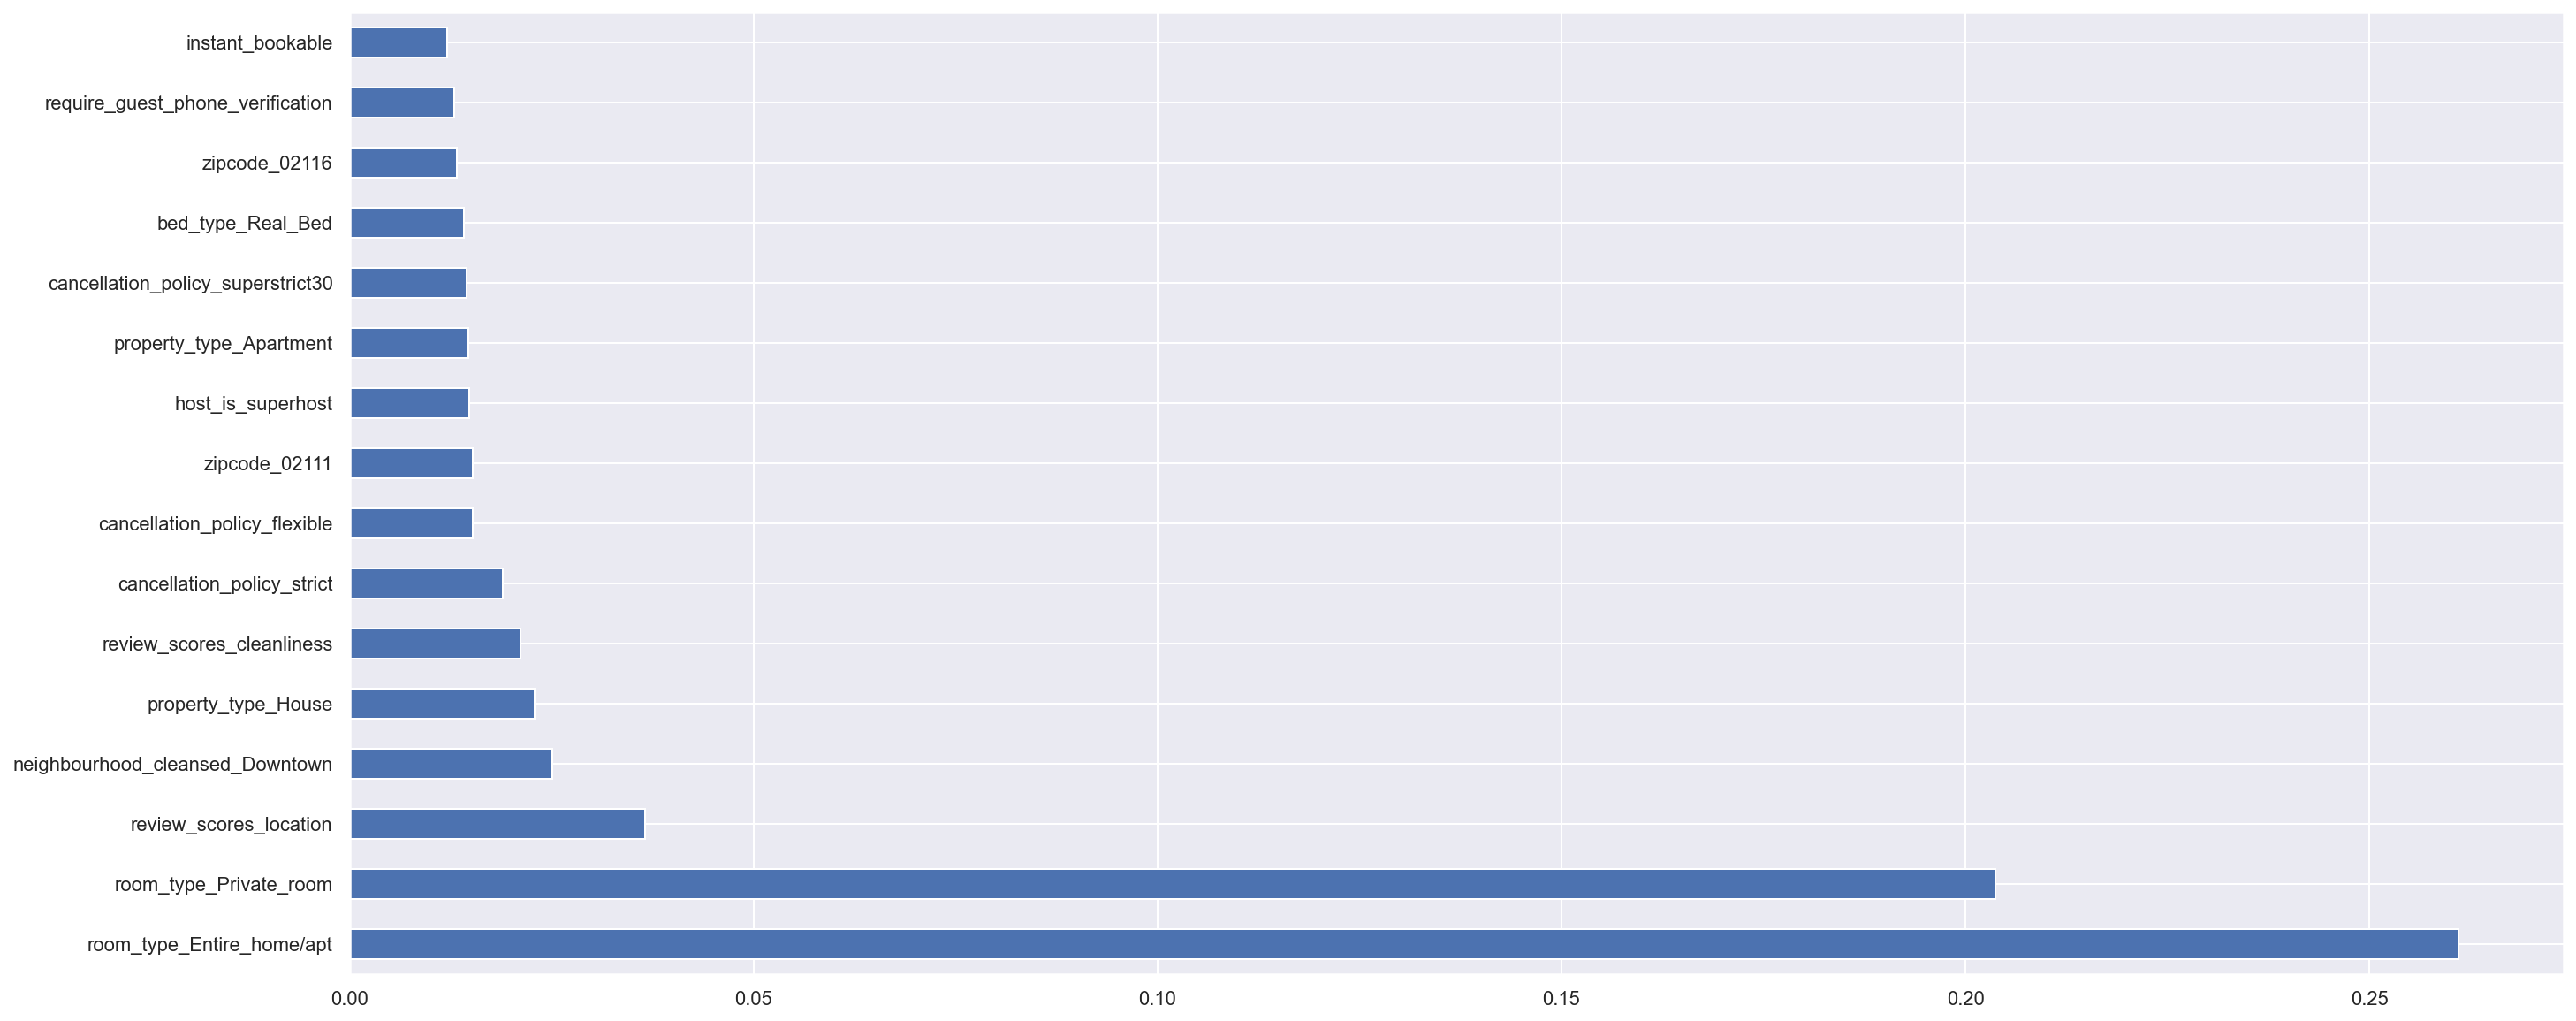

Top 20 Selected features:
 room_type_Entire_home/apt               0.261008
room_type_Private_room                  0.203737
review_scores_location                  0.036582
neighbourhood_cleansed_Downtown         0.025128
property_type_House                     0.022863
review_scores_cleanliness               0.021106
cancellation_policy_strict              0.018971
cancellation_policy_flexible            0.015271
zipcode_02111                           0.015238
host_is_superhost                       0.014765
property_type_Apartment                 0.014653
cancellation_policy_superstrict30       0.014525
bed_type_Real_Bed                       0.014196
zipcode_02116                           0.013261
require_guest_phone_verification        0.012979
instant_bookable                        0.012063
neighbourhood_cleansed_Jamaica_Plain    0.012039
zipcode_02109                           0.012024
neighbourhood_cleansed_Allston          0.011143
cancellation_policy_moderate            0.

In [28]:
# The feature selection by RandomForest
feat_importances = rf_feat_importances(optimized_rf)

### 2.3.5 Select features by feature importances and threshold
- Perform the feature selection by accumulating(descending) the importance of features until the number meets the threshold. 
- The features that are not in the accumulation, are dropped.

In [29]:
# Perform feature selection 
selected_feats = feature_selection(X, feat_importances, threshold = 0.99)
selected_feats.head()

,room_type_Entire_home/apt,room_type_Private_room,review_scores_location,neighbourhood_cleansed_Downtown,property_type_House,review_scores_cleanliness,cancellation_policy_strict,cancellation_policy_flexible,zipcode_02111,host_is_superhost,property_type_Apartment,cancellation_policy_superstrict30,bed_type_Real_Bed,zipcode_02116,require_guest_phone_verification,instant_bookable,neighbourhood_cleansed_Jamaica_Plain,zipcode_02109,neighbourhood_cleansed_Allston,cancellation_policy_moderate,neighbourhood_cleansed_Dorchester,zipcode_02114,room_type_Shared_room,is_location_exact,neighbourhood_cleansed_South_End,neighbourhood_cleansed_Chinatown,zipcode_02130,neighbourhood_cleansed_Back_Bay,zipcode_02134,property_type_Condominium,neighbourhood_cleansed_Beacon_Hill,zipcode_02135,neighbourhood_cleansed_South_Boston_Waterfront,zipcode_02131,zipcode_02210,neighbourhood_cleansed_South_Boston,zipcode_02129,neighbourhood_cleansed_East_Boston,zipcode_02118,neighbourhood_cleansed_Brighton,zipcode_02128,zipcode_02127,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Bay_Village,property_type_Boat,require_guest_profile_picture,zipcode_02215,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_North_End,zipcode_02113,neighbourhood_cleansed_Roxbury,zipcode_02108,property_type_Townhouse,bed_type_Futon,zipcode_02110,neighbourhood_cleansed_Fenway,property_type_Loft,bed_type_Airbed,zipcode_02124,zipcode_02125,neighbourhood_cleansed_West_Roxbury,zipcode_02115,zipcode_02119,neighbourhood_cleansed_Mission_Hill,review_scores_checkin,zipcode_02121,zipcode_02120,zipcode_02136,neighbourhood_cleansed_West_End,bed_type_Pullout_Sofa
0,0,1,9.0,0,0,9.0,0,0,0,False,1,0,1,0,False,True,0,0,0,1,0,0,0,True,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0
1,0,1,9.0,0,0,9.0,0,0,0,True,1,0,1,0,False,False,0,0,0,1,0,0,0,True,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0
2,0,1,9.0,0,1,10.0,0,1,0,True,0,0,1,0,False,False,0,0,0,0,0,0,0,True,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0
3,0,1,9.0,0,0,10.0,0,1,0,True,0,0,1,0,False,False,0,0,0,0,0,0,0,True,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0
4,1,0,9.0,0,0,10.0,1,0,0,False,1,0,1,0,False,False,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0


# 3. Build a model
- After we selected the features that important to our prediction, we put that features to create the model

## 3.2 Split data to training and testing datasets

In [30]:
#Split data into train and test dataset
X_train,X_test,y_train,y_test = train_test_split(selected_feats, y, test_size=0.2, random_state=42) 

## 3.3 Build and train Random Forest model for predict the price
- Optimizing hyperparameters by gridseach and cross-validation. Then return the optimized Random forest model

In [31]:
optimized_rf = rf_best_para(X_train, y_train, 5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1985 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.4min finished


{'bootstrap': True, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}


## 3.4 Evaluate the optimized Random Forest price prediction model

In [32]:
#Apply optimize hyperparameters to RF model
#Optimize the RF Model Performance
print ('\nOptimize RF Model Performance')
best_rf = optimized_rf.best_estimator_
rf_evaluate(best_rf, X_test, y_test)


Optimize RF Model Performance
Model Performance
Average Error: 37.4391 degrees.
Accuracy = 73.77%.


73.77017687642207

# 4. Data visualization for the 1st question 
These are the data visualizatons that used to answer the question " What factors affect price fluctuations".

<br><img src="images/1st_question_feature_importance.png" align="left"/><br>

- The bar chart illustrates the top 5 factors that affect price fluctuation by feature importance in the range percentage of 0 to 1. 
- The top 5 factors are the result of the RandomForest from the price prediction in the Boston Airbnb dataset.

## 4.1 review_scores_cleanliness

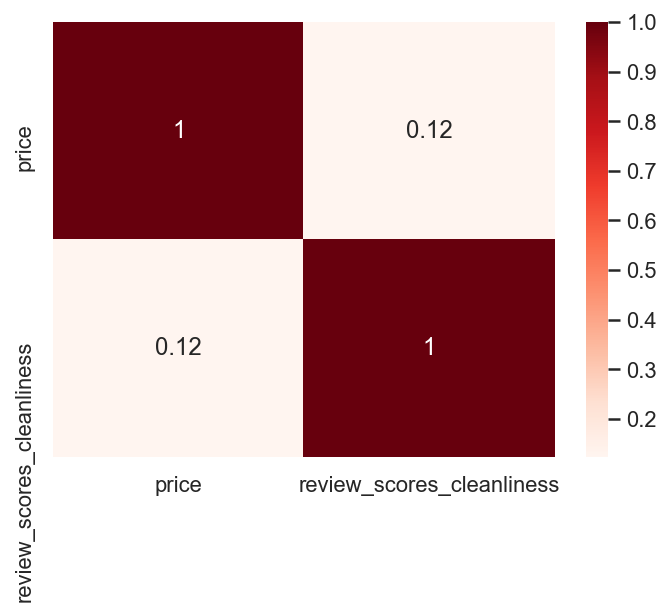

10.0    1162
9.0      370
8.0       27
Name: review_scores_cleanliness, dtype: int64

In [33]:
plot_corr(filtered_features, 'price','review_scores_cleanliness')
filtered_features['review_scores_cleanliness'].value_counts()

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


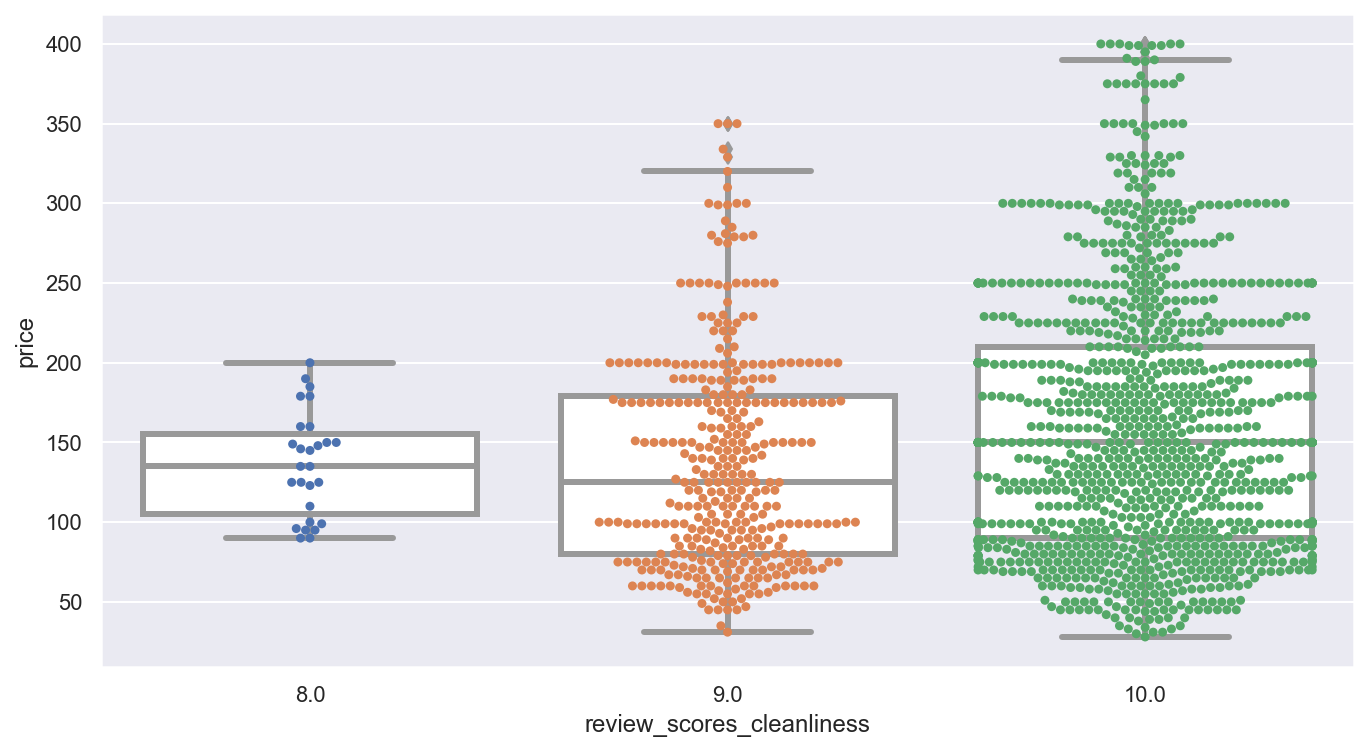

In [34]:
plot_swarmbox(filtered_features,'review_scores_cleanliness','price', size_x=10)

## 4.2 property_type

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


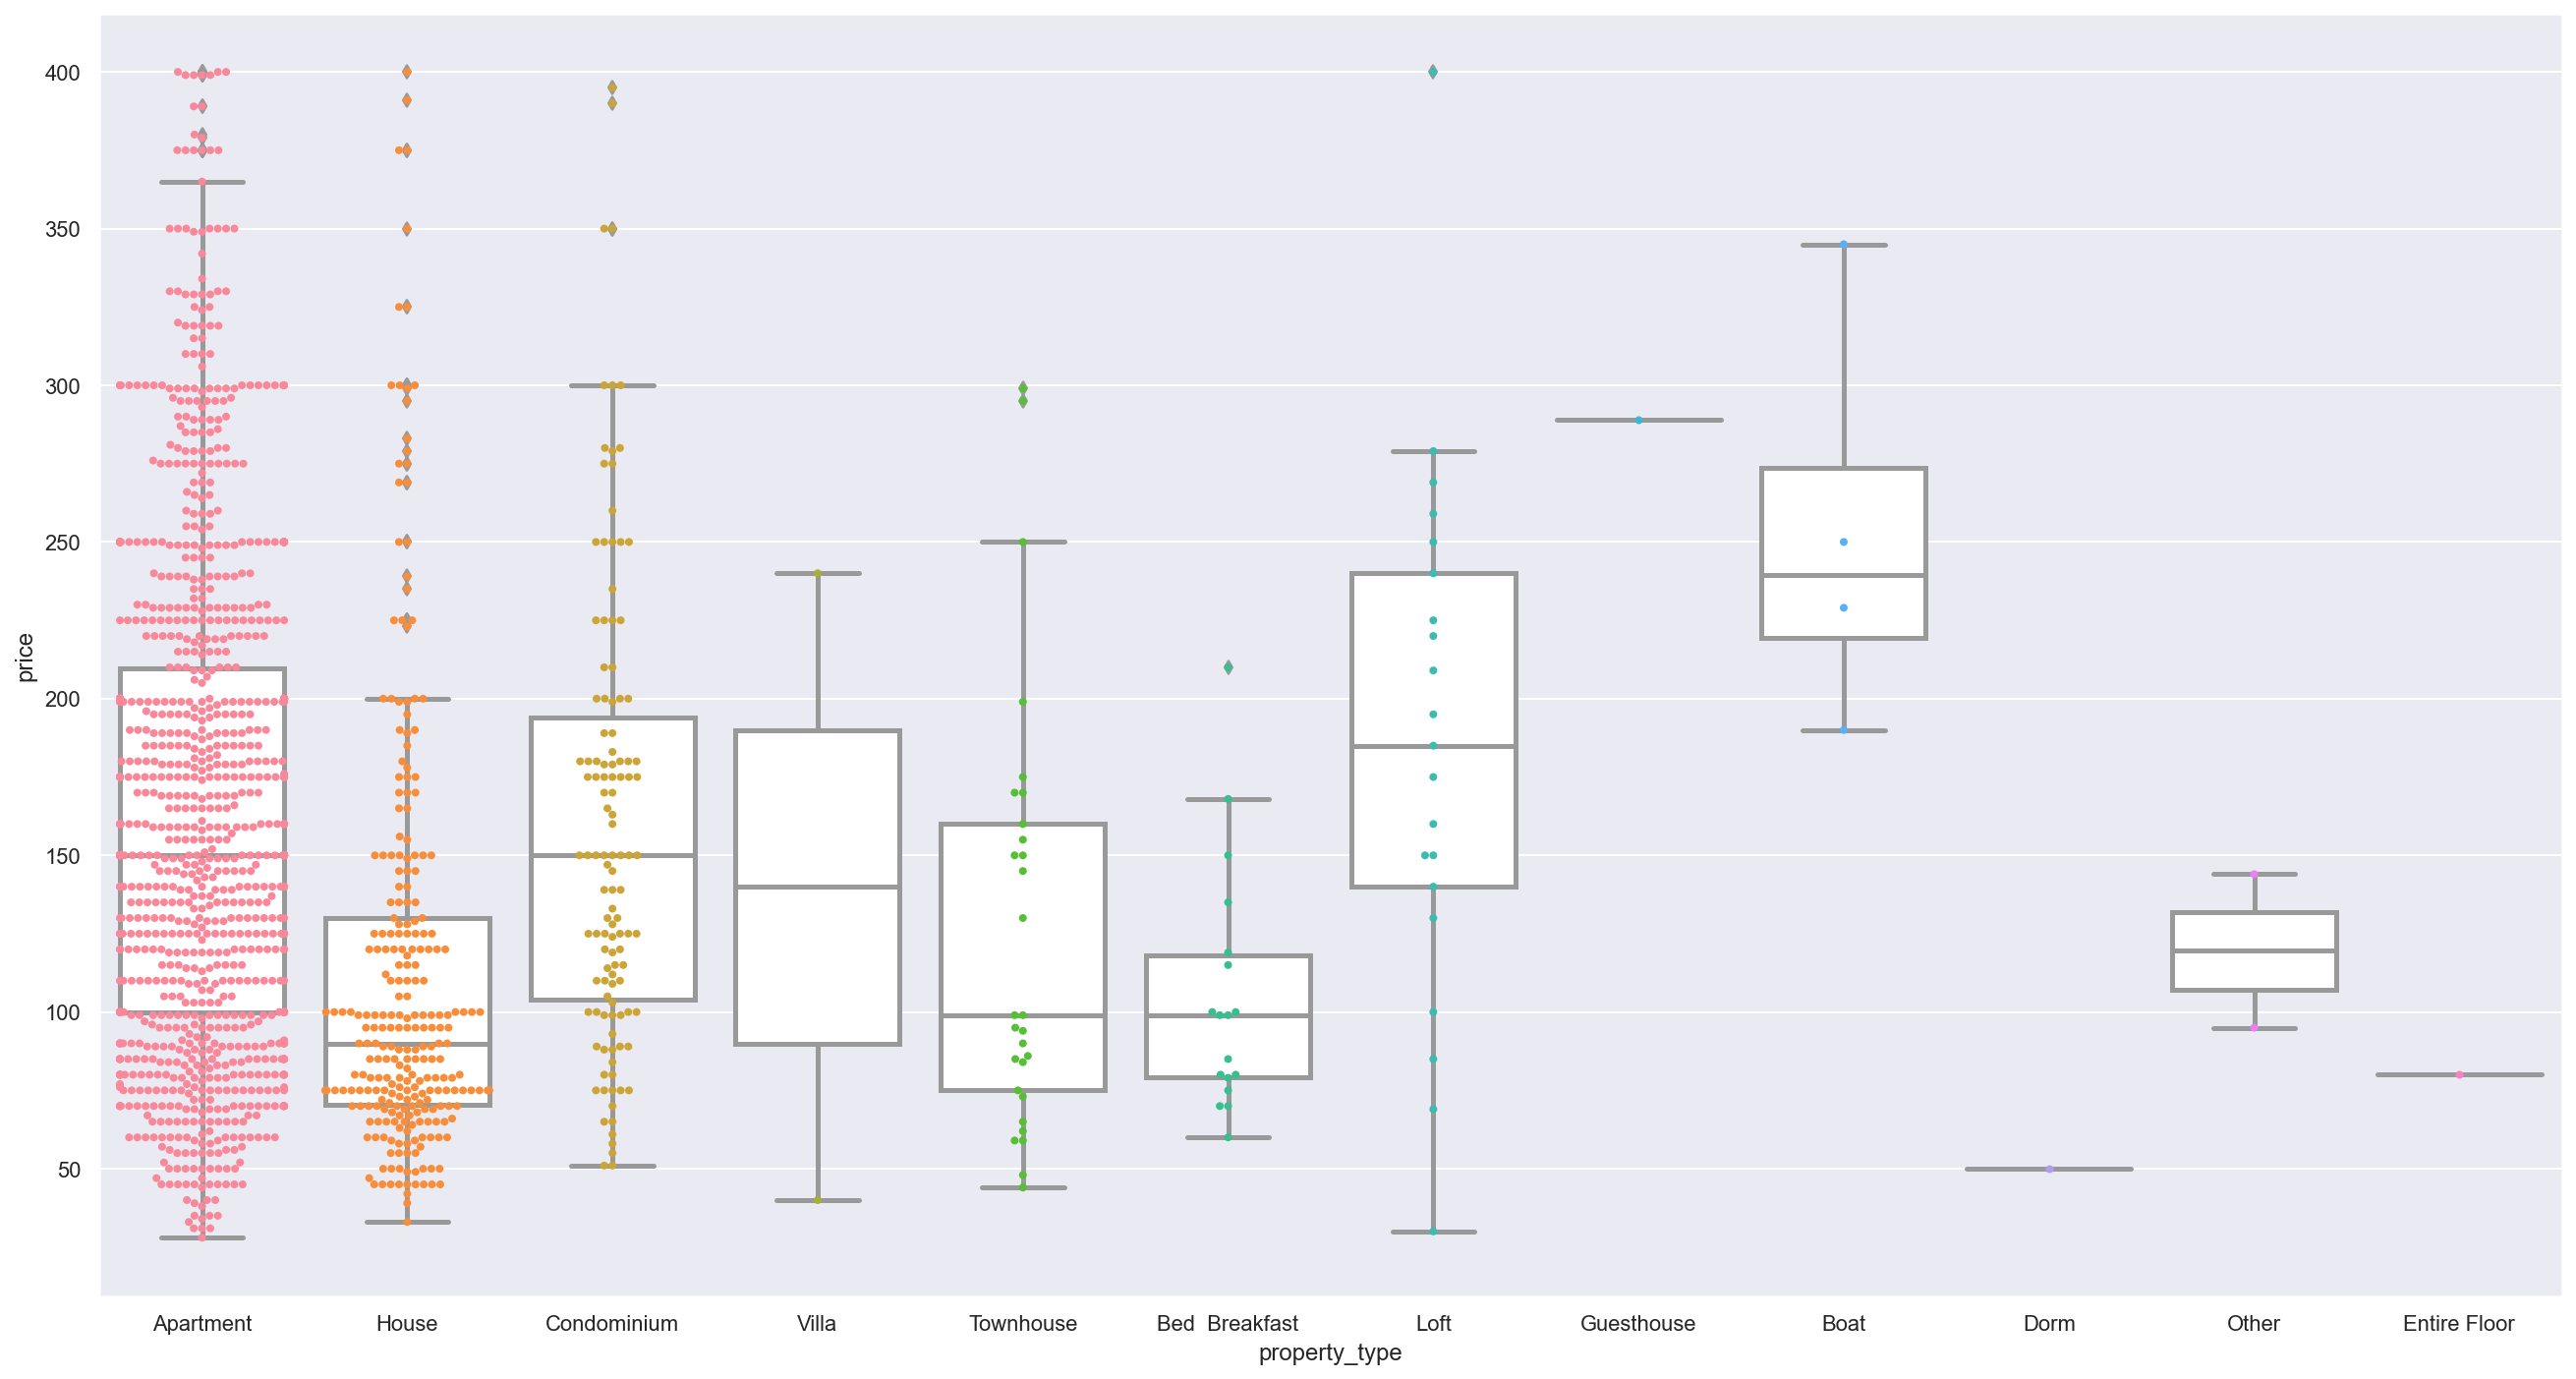

In [35]:
plot_swarmbox(filtered_features, 'property_type', 'price',20,12,4)

In [36]:
model = ols('price ~ property_type', data=filtered_features).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
property_type,6.867943e+05,11.0,10.784037,2.174287e-19
Residual,8.956595e+06,1547.0,NaN,NaN


## 4.3 neighbourhood_cleansed

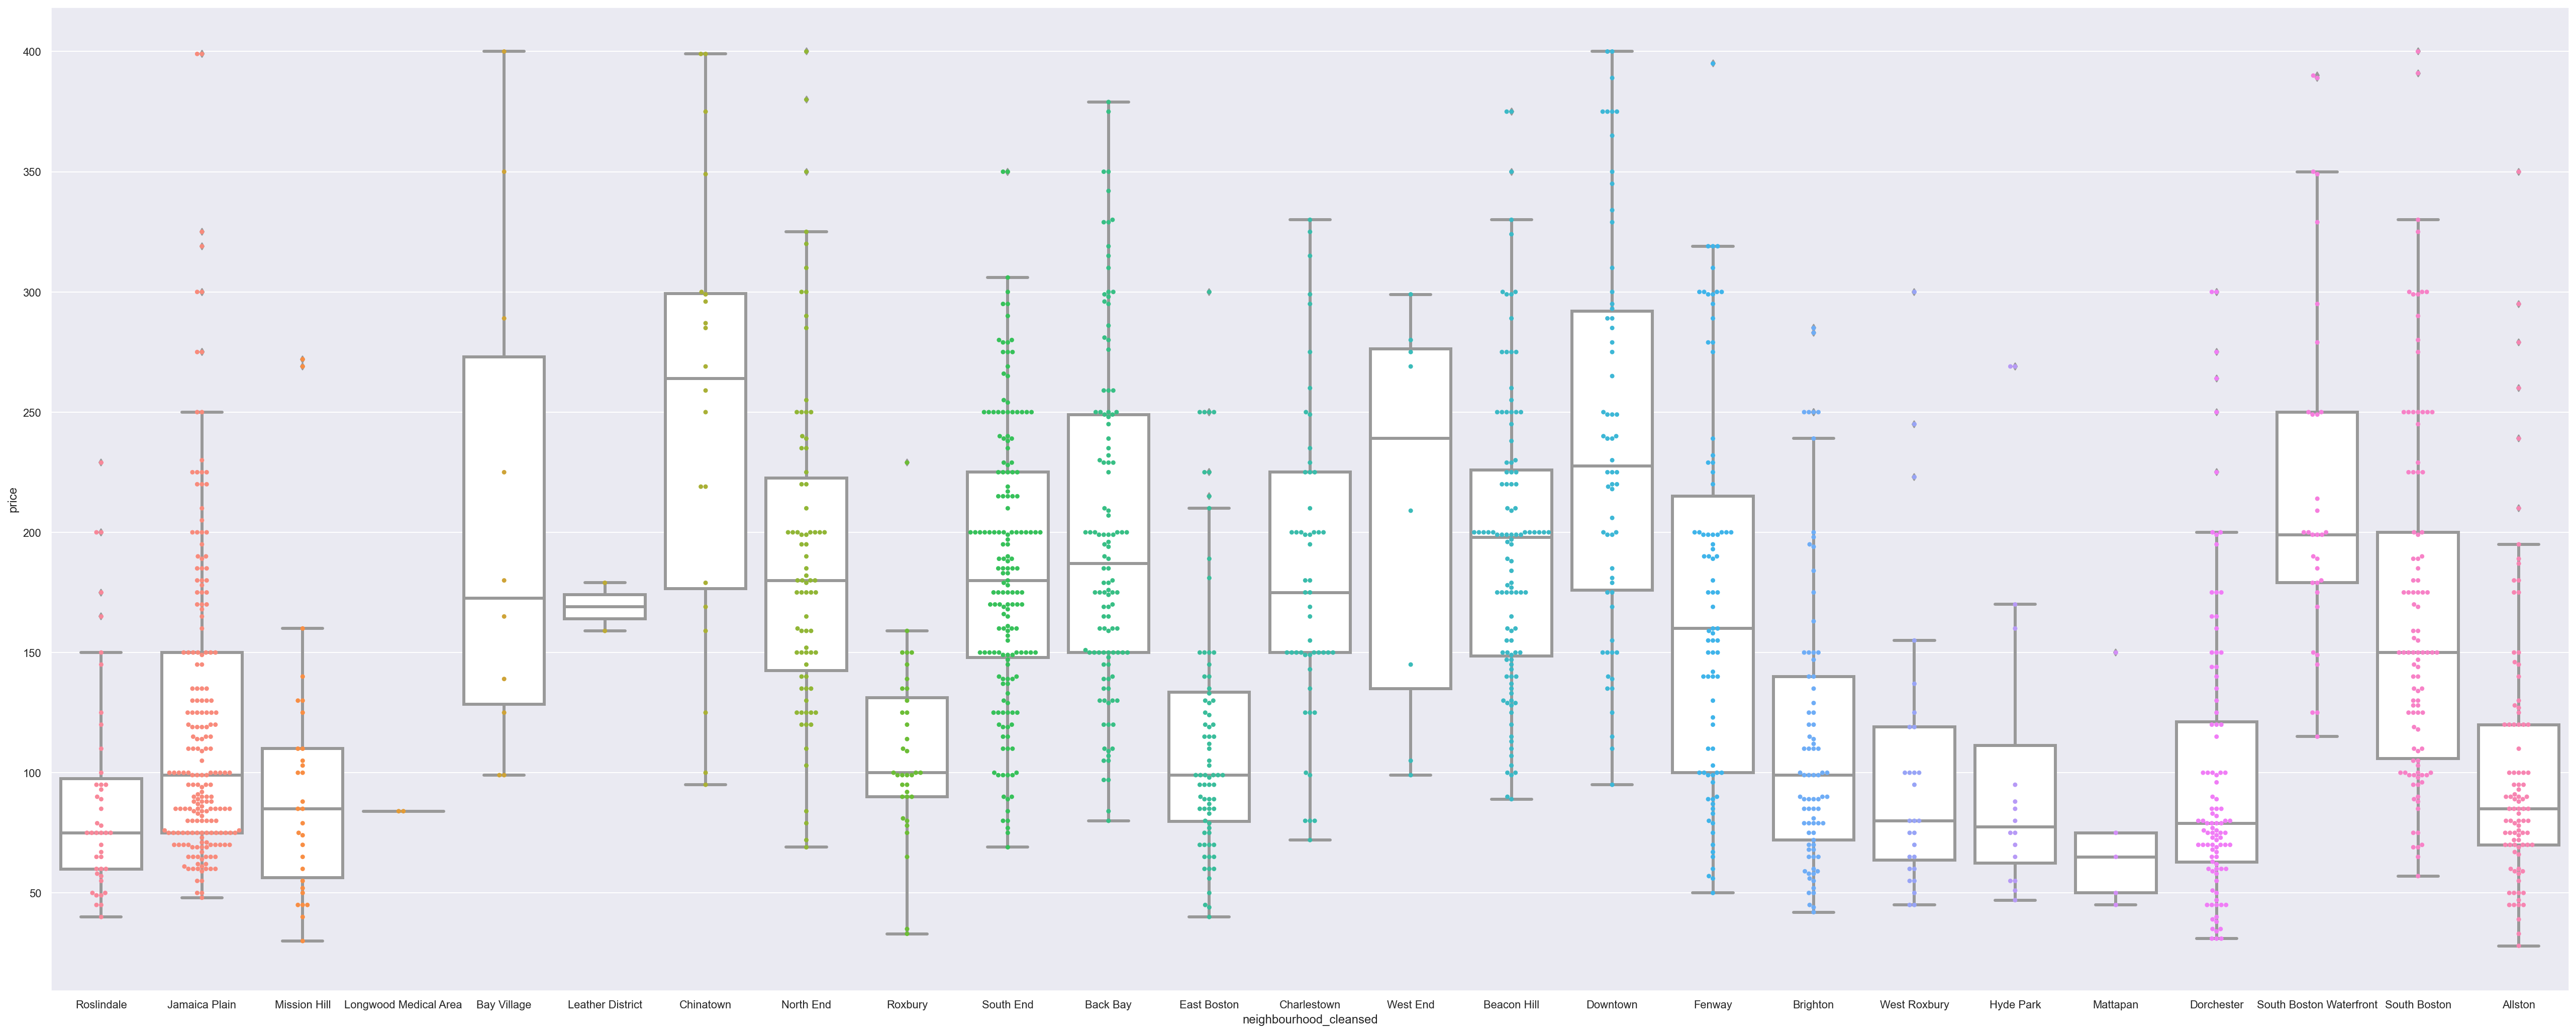

In [37]:
plot_swarmbox(filtered_features, 'neighbourhood_cleansed', 'price', 40, 18)

In [38]:
tmper_df = filtered_features[['price','neighbourhood_cleansed']]
df1 = tmper_df.groupby('neighbourhood_cleansed').count()
df2 = tmper_df.groupby('neighbourhood_cleansed').mean()
df1['mean'] = df2['price']
df1.rename(columns=({'price': 'count'})).sort_values('count', ascending=False)

,count,mean
neighbourhood_cleansed,,
Jamaica Plain,201,120.298507
South End,167,184.341317
Back Bay,116,200.439655
Beacon Hill,108,194.814815
South Boston,102,166.862745
Dorchester,100,99.650000
Allston,95,103.305263
Fenway,86,173.186047
Brighton,81,113.543210


In [39]:
model = ols('price ~ neighbourhood_cleansed', data=filtered_features).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
neighbourhood_cleansed,3.123935e+06,24.0,30.627033,2.471413e-112
Residual,6.519454e+06,1534.0,NaN,NaN


## 4.4 review_scores_location

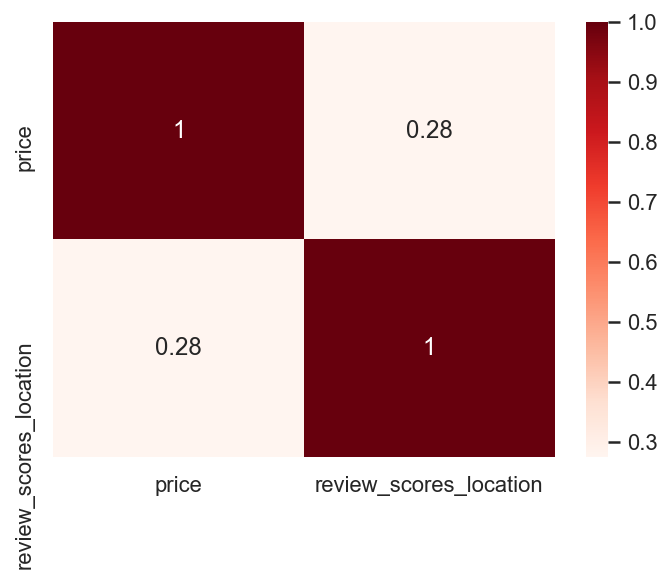

10.0    1094
9.0      465
Name: review_scores_location, dtype: int64

In [40]:
plot_corr(filtered_features,'price','review_scores_location')
filtered_features['review_scores_location'].value_counts()

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


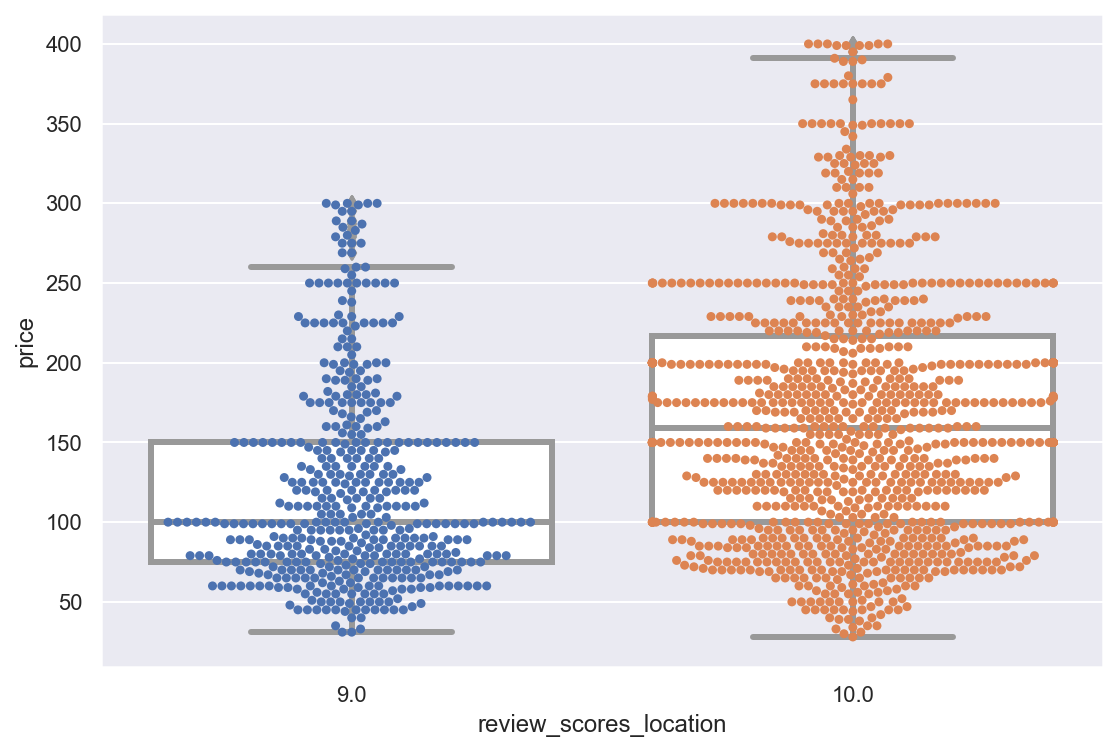

In [41]:
plot_swarmbox(filtered_features,'review_scores_location','price')

## 4.5 room_type

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


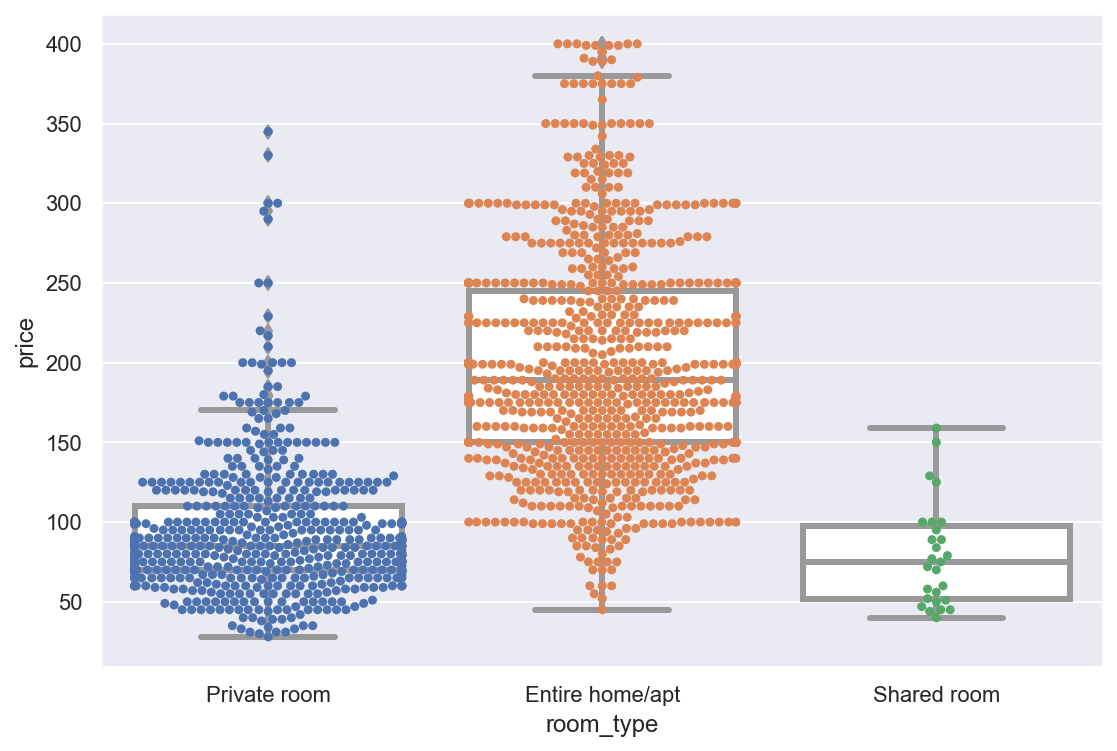

In [42]:
plot_swarmbox(filtered_features,'room_type','price')

In [43]:
model = ols('price ~ room_type', data=filtered_features).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
room_type,4.144358e+06,2.0,586.341603,1.629061e-190
Residual,5.499031e+06,1556.0,NaN,NaN


# The 2nd question: What factors affect customer satisfaction?
I will predict the review score/customer statisfaction (target) to find what factors affect customer satisfaction?

# 1. Data preparation
- Begin the data preparation or data cleansing

## 1.1 Drop unused features
- Drop the features that are not good in predictions. <br>
- The reasons why i drop these features are in the comment above the list of dropped columns/features.

In [47]:
             # Require NLP to interpret (Out of quesiton scope)
drop_cols = ['name','summary','space','description','neighborhood_overview','notes','transit','access','interaction',
             'house_rules','host_about',# Require NLP to interpret (Out of quesiton scope)
             # Doesn't provide meaningful information.
             'host_name', 'accommodates',
             # Unbalanced unique value (one unqiue value dominates other unique value in the number)
             # The Unbalanced unique value doesn't give meaningful information to analysis
             'street', 'city','host_location', 'smart_location','host_acceptance_rate', 'host_response_rate', 'market',
             'availability_30','availability_60','availability_90','availability_365',
             'host_listings_count', 'host_total_listings_count','calculated_host_listings_count','minimum_nights','maximum_nights',
             # Duplicate with neighbourhood_cleansed
             'neighbourhood',
             # Decrease the model accuarcy and has many NaN values.
             'host_neighbourhood', 'host_verifications', 'amenities', 'beds','bedrooms','bathrooms', 'host_response_time',
             # Have directly the relationship with price ($ dollars) which we already used price to predict
             'cleaning_fee','extra_people','security_deposit','guests_included',
             # I will not use these date features to analyse the dataset
             'calendar_updated','host_since','first_review','last_review',
             # Have high relation with other undrop review score features
             'review_scores_value','number_of_reviews','reviews_per_month','review_scores_accuracy']
             # Filter out uninterpretable ID and URL columns
boston_data = raw_boston_data.loc[:, ~raw_boston_data.columns.str.contains('id|url')].drop(drop_cols, axis=1).copy()
# Show dropped columns
print ('Dropped url and id columns: ')
print (raw_boston_data.loc[:, raw_boston_data.columns.str.contains('id|url')].columns.values)

Dropped url and id columns: 
['id' 'listing_url' 'scrape_id' 'thumbnail_url' 'medium_url' 'picture_url'
 'xl_picture_url' 'host_id' 'host_url' 'host_thumbnail_url'
 'host_picture_url' 'host_identity_verified']


## 1.2 Drop columns that has an unbalanced unique value ratio
- Drop the columns that have an unbalanced unique value ratio (one unique value or excessive unique values).
<br> Note: One unique value or too many unique values inside the columns doesn't give a good analysis because they doesn't give meaningful information.

In [48]:
# Drop the column that has an unbalanced unique value ratio
unique_filtered = drop_unbalanced_ratio(boston_data)


Dropped unbalanced ratio columns...
last_scraped
experiences_offered
neighbourhood_group_cleansed
state
country_code
country
latitude
longitude
has_availability
calendar_last_scraped
requires_license
license
jurisdiction_names


## 1.3 Transform boolean string to boolean type

In [49]:
# Transform boolean string to boolean type
cleaned_bool= string2bool(unique_filtered)


Converted boolean string to boolean type...
host_is_superhost
host_has_profile_pic
is_location_exact
instant_bookable
require_guest_profile_picture
require_guest_phone_verification


## 1.4 Remove special character

In [50]:
# Remove special characters in DataFrame
removed_spl = remove_spl_char(cleaned_bool)


Removing special character...
price
weekly_price
monthly_price


## 1.5 Drop missing values (NaN)
- To set missing values threshold, set nan_threshold to 0.75: 1-0.75=0.25->25%, if you want drop the columns that has missing value more than 25%. Because we calculate nan_thershold from missing value mean.

In [51]:
nan_threshold = 0.75
# Drop the columns that has missing values more than the missing value threshold
mis_columns = removed_spl.columns[removed_spl.isnull().mean()>nan_threshold]
removed_spl.drop(mis_columns, axis=1, inplace=True)

print('Dropped columns that contains missing value > ', (1-nan_threshold)*100,'%: ')
print(list(mis_columns))

Dropped columns that contains missing value >  25.0 %: 
['weekly_price', 'monthly_price', 'square_feet']


### 1.5.1 Drop missing values (NaN) in the target column

In [52]:
# Drop missing values (NaN) in label/target column
standard_cleaned_df = removed_spl.dropna(subset=['review_scores_rating'],axis=0).copy()

# Reset index after dropped the rows contain missing values
standard_cleaned_df.reset_index(drop=True, inplace=True)
standard_cleaned_df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,zipcode,is_location_exact,property_type,room_type,bed_type,price,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
0,False,True,Roslindale,02131,True,Apartment,Private room,Real Bed,65.0,True,moderate,False,False,94.0,9.0,10.0,10.0,9.0
1,True,True,Roslindale,02131,True,Apartment,Private room,Real Bed,65.0,False,moderate,True,False,98.0,9.0,10.0,10.0,9.0
2,False,True,Roslindale,NaN,False,House,Private room,Real Bed,75.0,False,moderate,False,False,100.0,10.0,10.0,10.0,10.0
3,True,True,Roslindale,02131,True,House,Private room,Real Bed,79.0,False,flexible,False,False,99.0,10.0,10.0,10.0,9.0
4,True,True,Roslindale,02131,True,Condominium,Private room,Real Bed,75.0,False,flexible,False,False,100.0,10.0,10.0,10.0,9.0


### 1.5.2 Drop missing values (NaN) before removed outliner
- Because isolate forest machine learning technique can't hanndle NaN.

In [53]:
# Drop the rows that contain missing values 
standard_cleaned_df.dropna(axis=0, inplace=True)
# Reset index after dropped the rows that contain missing values
standard_cleaned_df.reset_index(drop=True, inplace=True)

## 1.6 Remove outliers
An outlier is a crucial problem that makes our model inaccurate and inefficient. we should handle it before performing any actor that relates to machine learning or modeling.

### 1.6.1 Separate numeric and non-numeric columns/features
- Because we only remove outiler for numeric type

In [54]:
# Separate numeric and non-numeric features
numeric_feats = standard_cleaned_df.select_dtypes(include='number')
non_num_feats = standard_cleaned_df.select_dtypes(exclude='number')

### 1.6.2 The statistic z-score
- Filter outliner by statistic z score.

In [55]:
# Remove outliers by statistic z-score method
z_anomaly_solved = z_outlier_filter(numeric_feats)

### 1.6.3 Isolation Forest
- Isolation Forest is an outlier detection technique that identifies anomalies instead of normal observations
- The Isolation Forest isolate observations into abnormal vs normal observations by the following step:
<br><img src="images/Isolation_forest_pic.png" align="left"/>

- At each node in the decision tree, randomly select a feature then selecting a splitting value between maximum and minimum values of the selected feature/column to split the dataset into two.
- After that, keep doing the above step until all observations are isolated from each other.
- The anomalies are detected by finding the observation that is isolated faster or easier than other observations because the anomalies are normally far from normal observations.

In [56]:
# Remove outliers by manchine learning method
anomaly_solved = ML_outlier_filter(z_anomaly_solved)

### 1.6.4 Merge numeric and categorical columns

In [57]:
# Combine numeric features and catergorical features
non_num_feats_df = pd.DataFrame(non_num_feats,index = anomaly_solved.index)
removed_outlier = pd.concat([non_num_feats_df, anomaly_solved], axis=1)

# Reset index after dropped the rows that contain missing values
removed_outlier.reset_index(drop=True, inplace=True)
removed_outlier.shape

(1646, 18)

### 1.6.5 Check unique value in columns again after drop outlier. 

In [58]:
# Drop the columns that has an unbalanced unique value ratio after removed outliers
removed_outlier = drop_unbalanced_ratio(removed_outlier)


Dropped unbalanced ratio columns...


### Also drop review_scores_communication and review_scores_checkin because 
- Decrease model accuracy 
- Have unbalanced unique values you can be seen from unique value counts below

In [59]:
removed_outlier['review_scores_communication'].value_counts()

10.0    1584
9.0       62
Name: review_scores_communication, dtype: int64

In [60]:
removed_outlier['review_scores_checkin'].value_counts()

10.0    1604
9.0       42
Name: review_scores_checkin, dtype: int64

In [61]:
removed_outlier.drop(['review_scores_communication','review_scores_checkin'],axis=1, inplace=True)

# 2. Feature selection
- The process that searching and selecting the most useful features in the dataset and discard unnecessary features. 
- The feature selection step is an important step in data preparation because it ditches the unimportant features that decrease training speed, accuracy and interpretation of the model.
#### Due to the high number of features, i need to perform automatic features selection fucntions.

In [62]:
# Drop the columns that has an unbalanced unique value ratio after removed outliers
anomaly_solved = drop_unbalanced_ratio(anomaly_solved)
    
# Combine numeric features and catergorical features
non_num_feats_df = pd.DataFrame(non_num_feats,index = anomaly_solved.index)
removed_outlier = pd.concat([non_num_feats_df, anomaly_solved], axis=1)

# Reset index after dropped the rows that contain missing values
removed_outlier.reset_index(drop=True, inplace=True)
removed_outlier.shape


Dropped unbalanced ratio columns...


(1646, 18)

## 2.1 Pearson's correlation
Pearson correlation is the relationship between the two numeric variables. A relationship value or correlation can interpret as follows in the range of -1 to 1.
<br> Calculate correlations or relationships between columns then drop the high correlation columns by using a correlation threshold.
- Correlation > 0; There is a positive relationship.
- Correlation < 0; There is a negative relationship.
- Correlation = 0; There isn't a relationship.

## Drop review_scores_communication, review_scores_checkin because 
- Decrease the model accuracy.
- Have unbalanced unique values you can be seen from unique value counts below.

In [63]:
removed_outlier['review_scores_communication'].value_counts()

10.0    1584
9.0       62
Name: review_scores_communication, dtype: int64

In [64]:
removed_outlier['review_scores_checkin'].value_counts()

10.0    1604
9.0       42
Name: review_scores_checkin, dtype: int64

In [65]:
removed_outlier.drop(['review_scores_communication','review_scores_checkin'],axis=1, inplace=True)

We can also use the heat map to provides a clear picture of the correlation between the columns as in the figure above. The correlation heat map can be interpreted as follow.
- The darker colour the greater the correlation value.
- The lighter colour the less the correlation value.

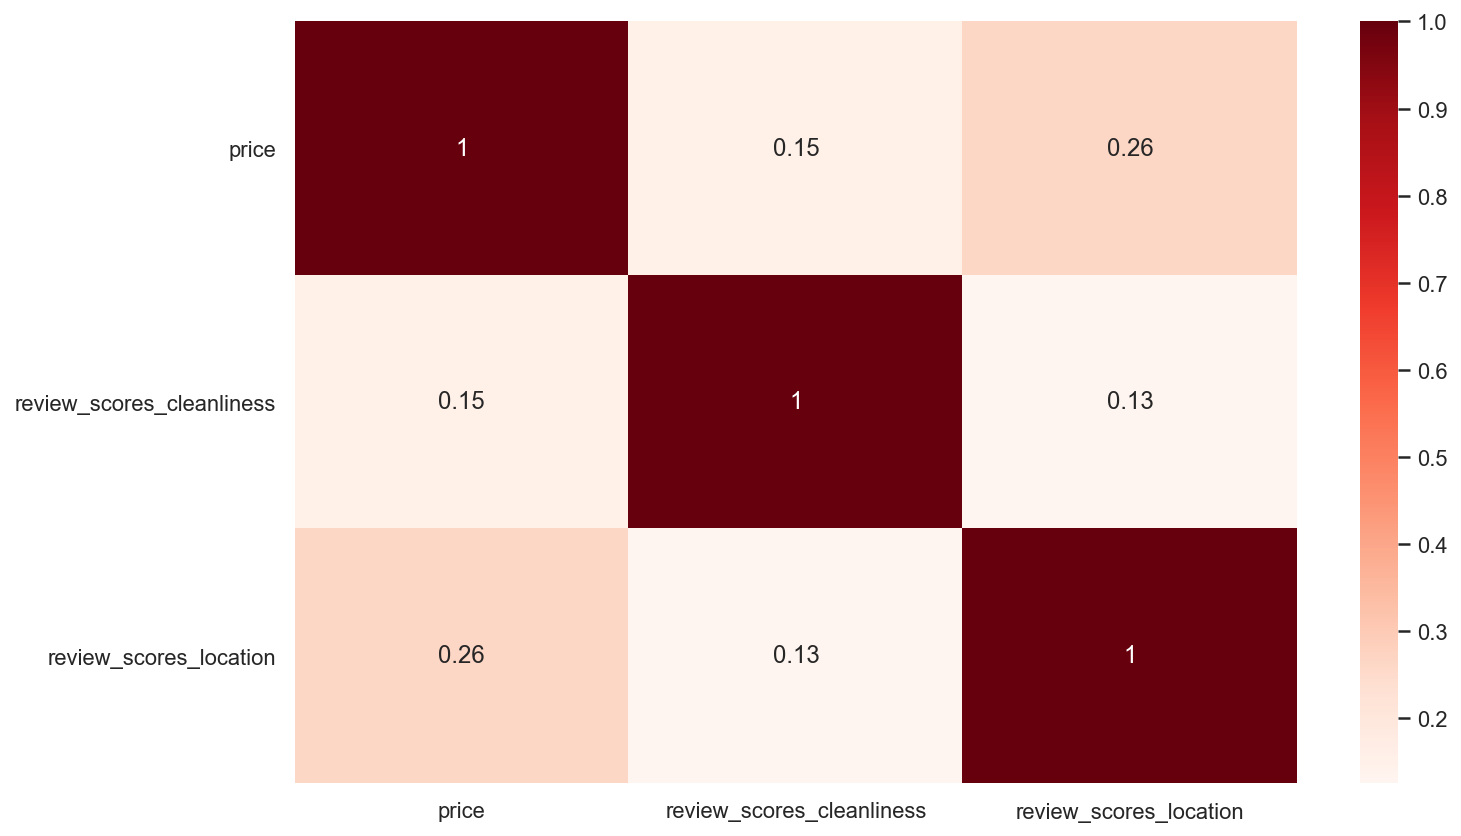

In [66]:
# Show column correlations for numeric valuesWe can drop the high correlation columns because
plot_pearson_corrs(removed_outlier.select_dtypes(include='number').drop('review_scores_rating',axis=1))

### 2.2.1 Drop high correlation features by Pearson's correlation
#### The threshold is ranged between 0 and 1 because it is an absolute of relationship value.

We can drop high correlation columns because:
- The column that has a high relationship with other columns, can represent each other. Therefore we can just keep one of them. <br> 

In [67]:
# Remove high correlation features
filtered_features = remove_high_corr(removed_outlier, 0.75)
filtered_features.shape

Dropped high correlation column... 

Dropped unbalanced ratio columns...


(1646, 16)

## 2.3 Random Forest
- Random Forest machine learning is a combination of multiple different decision trees that vote for the best result.
- A decision tree is a diagram that is used to determine a the decision making.
<br><img src="images/random_forest_pic.png" align="left"/>

### 2.3.1 Create dummies for categorical values
- If categorical values presents in your dataframe before put that values in the machine learning, you must convert to numeric value or one-hot encoding before assign that dataframe.

In [68]:
# Select features by drop the target column
X_features = filtered_features.drop('review_scores_rating', axis = 1)

# Add dummies to DataFrame by put in categorical values
dummies_data = pd.get_dummies(X_features, prefix_sep='_', dummy_na=False)
# Remove space ' ' and place it with '_' to make column names easiler to analyse.
dummies_data.columns = dummies_data.columns.str.replace(' ', '_')
dummies_data.head()

,host_is_superhost,host_has_profile_pic,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,price,review_scores_cleanliness,review_scores_location,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back_Bay,neighbourhood_cleansed_Bay_Village,neighbourhood_cleansed_Beacon_Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East_Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde_Park,neighbourhood_cleansed_Jamaica_Plain,neighbourhood_cleansed_Leather_District,neighbourhood_cleansed_Longwood_Medical_Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission_Hill,neighbourhood_cleansed_North_End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South_Boston,neighbourhood_cleansed_South_Boston_Waterfront,neighbourhood_cleansed_South_End,neighbourhood_cleansed_West_End,neighbourhood_cleansed_West_Roxbury,zipcode_02108,zipcode_02108_02111,zipcode_02109,zipcode_02110,zipcode_02111,zipcode_02113,zipcode_02114,zipcode_02115,zipcode_02116,zipcode_02118,zipcode_02119,zipcode_02120,zipcode_02121,zipcode_02122,zipcode_02124,zipcode_02125,zipcode_02126,zipcode_02127,zipcode_02128,zipcode_02129,zipcode_02130,zipcode_02131,zipcode_02132,zipcode_02134,zipcode_02135,zipcode_02136,zipcode_02138,zipcode_02141,zipcode_02145,zipcode_02163,zipcode_02210,zipcode_02215,zipcode_02445,zipcode_02446,zipcode_02467,property_type_Apartment,property_type_Bed__Breakfast,property_type_Boat,property_type_Condominium,property_type_Dorm,property_type_Entire_Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Entire_home/apt,room_type_Private_room,room_type_Shared_room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pullout_Sofa,bed_type_Real_Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_superstrict30
0,False,True,True,True,False,False,65.0,9.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,True,True,True,False,True,False,65.0,9.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,True,True,True,False,False,False,79.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
3,True,True,True,False,False,False,75.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
4,False,True,False,False,False,False,100.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


### 2.3.2 Declare X (features) and y (target)

In [69]:
# Declare X, y
X = dummies_data  # Independent columns
y = filtered_features['review_scores_rating']   # Dependent column

### 2.3.3 Build Random Forest model for feature selection
- Optimizing hyperparameters by gridseach and cross-validation. Then return the optimized Random Forest model

In [70]:
# Optimizing Random Forest hyperparameters and finding optimize rf model
optimized_rf = rf_best_para(X, y, 5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1985 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.6min finished


{'bootstrap': False, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300, 'random_state': 42}


### 2.3.4 Find variable that related with review scores rating by the importance of feature

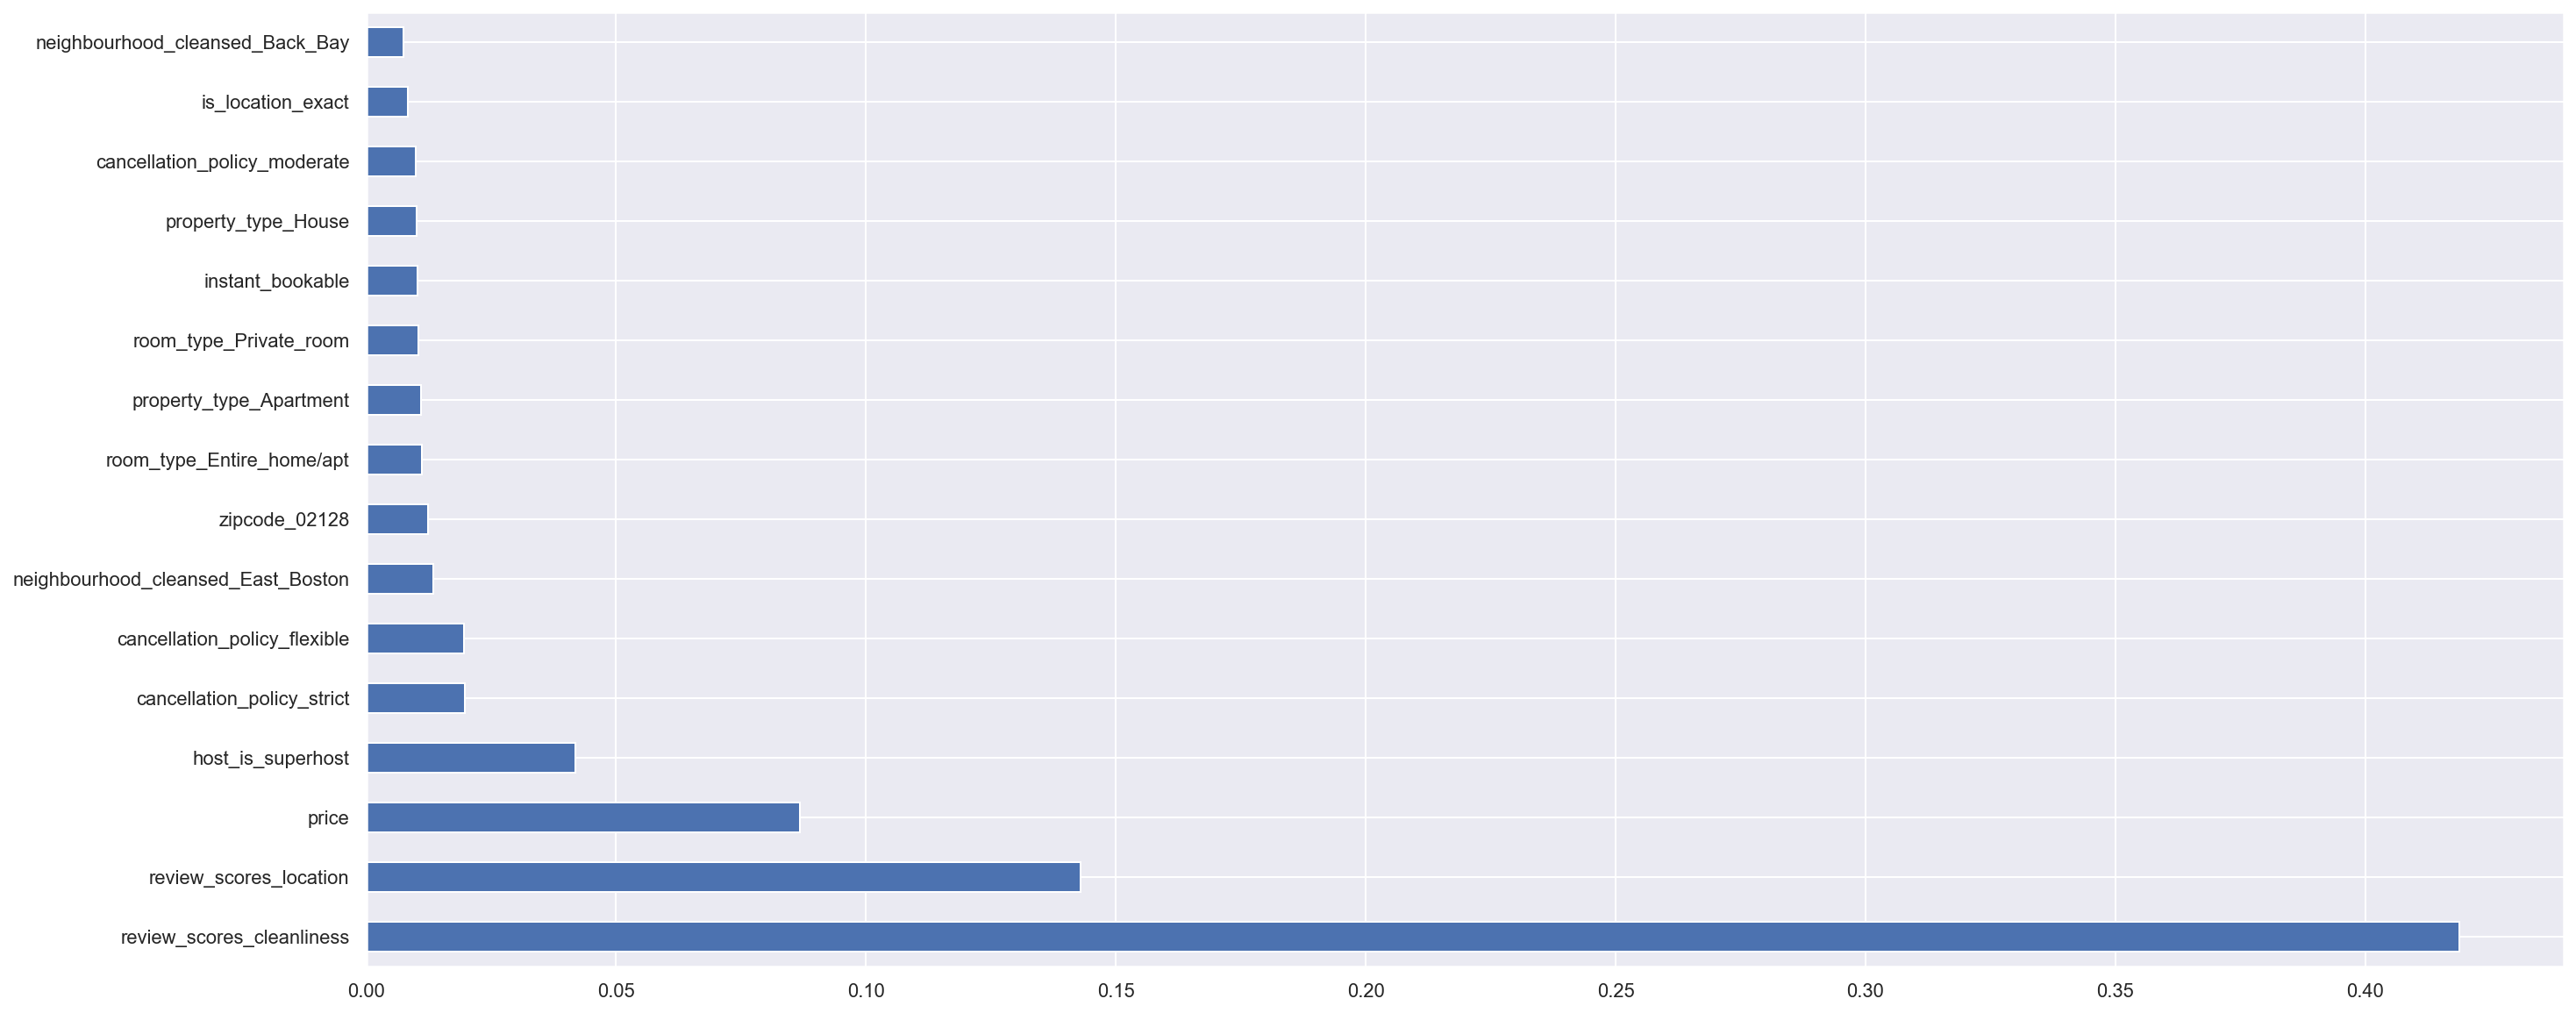

Top 20 Selected features:
 review_scores_cleanliness               0.418778
review_scores_location                  0.142875
price                                   0.086832
host_is_superhost                       0.041829
cancellation_policy_strict              0.019762
cancellation_policy_flexible            0.019612
neighbourhood_cleansed_East_Boston      0.013483
zipcode_02128                           0.012381
room_type_Entire_home/apt               0.011061
property_type_Apartment                 0.010917
room_type_Private_room                  0.010523
instant_bookable                        0.010207
property_type_House                     0.010033
cancellation_policy_moderate            0.009848
is_location_exact                       0.008419
neighbourhood_cleansed_Back_Bay         0.007442
zipcode_02210                           0.006969
zipcode_02108                           0.006635
require_guest_phone_verification        0.006296
neighbourhood_cleansed_Jamaica_Plain    0.

In [71]:
# The feature selection by RandomForest
feat_importances = rf_feat_importances(optimized_rf)

### 2.3.5 Select features by feature importances and threshold
- Perform the feature selection by accumulating(descending) the importance of features until the number meets the threshold. 
- The features that are not in the accumulation, are dropped.

In [72]:
# Perform feature selection 
selected_feats = feature_selection(X, feat_importances, threshold = 0.99)
selected_feats.head()

,review_scores_cleanliness,review_scores_location,price,host_is_superhost,cancellation_policy_strict,cancellation_policy_flexible,neighbourhood_cleansed_East_Boston,zipcode_02128,room_type_Entire_home/apt,property_type_Apartment,room_type_Private_room,instant_bookable,property_type_House,cancellation_policy_moderate,is_location_exact,neighbourhood_cleansed_Back_Bay,zipcode_02210,zipcode_02108,require_guest_phone_verification,neighbourhood_cleansed_Jamaica_Plain,neighbourhood_cleansed_Beacon_Hill,zipcode_02116,zipcode_02135,neighbourhood_cleansed_Downtown,zipcode_02215,zipcode_02130,property_type_Condominium,neighbourhood_cleansed_South_Boston_Waterfront,neighbourhood_cleansed_Brighton,zipcode_02114,neighbourhood_cleansed_Dorchester,zipcode_02127,neighbourhood_cleansed_South_End,neighbourhood_cleansed_Allston,neighbourhood_cleansed_South_Boston,zipcode_02115,zipcode_02118,neighbourhood_cleansed_Fenway,zipcode_02134,neighbourhood_cleansed_Roxbury,zipcode_02119,zipcode_02131,zipcode_02124,cancellation_policy_superstrict30,bed_type_Real_Bed,zipcode_02111,zipcode_02129,neighbourhood_cleansed_North_End,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Chinatown,zipcode_02113,property_type_Loft,zipcode_02125,property_type_Bed__Breakfast,require_guest_profile_picture,zipcode_02109,zipcode_02163,zipcode_02122,zipcode_02136
0,9.0,9.0,65.0,False,0,0,0,0,0,1,1,True,0,1,True,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,False,0,0,0,0
1,9.0,9.0,65.0,True,0,0,0,0,0,1,1,False,0,1,True,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,True,0,0,0,0
2,10.0,9.0,79.0,True,0,1,0,0,0,0,1,False,1,0,True,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,False,0,0,0,0
3,10.0,9.0,75.0,True,0,1,0,0,0,0,1,False,0,0,True,0,0,0,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,False,0,0,0,0
4,10.0,9.0,100.0,False,1,0,0,0,1,1,0,False,0,0,False,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,False,0,0,0,0


# 3. Build a model
- After we selected the features that important to our prediction, we put that features to create the model

## 3.2 Split data to training and testing datasets

In [73]:
#Split data into train and test dataset
X_train,X_test,y_train,y_test = train_test_split(selected_feats, y, test_size=0.2, random_state=42) 

## 3.3 Build and train Random Forest model for predict the review scores rating
- Optimizing hyperparameters by gridseach and cross-validation. Then return the optimized Random forest model

In [74]:
optimized_rf = rf_best_para(X_train, y_train, 5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1985 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.9min finished


{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 42}


## 3.4 Evaluate the optimized Random Forest review scores rating prediction model

In [75]:
#Apply optimize hyperparameters to RF model
#Optimize the RF Model Performance
print ('\nOptimize RF Model Performance')
best_rf = optimized_rf.best_estimator_
rf_evaluate(best_rf, X_test, y_test)


Optimize RF Model Performance
Model Performance
Average Error: 2.2801 degrees.
Accuracy = 97.60%.


97.60262914760648

# 4. Data visualization for the 2nd question 
These are the data visualizatons that used to answer the question "What factors affect customer satisfaction".

<br><img src="images/2nd_question_feature_importance.png" align="left"/><br>

- The bar chart illustrates the top 5 factors that affect customer satisfaction fluctuation by feature importance in the range percentage of 0 to 1. 
- The top 5 factors are the result of the RandomForest from the review score rating or customer satisfaction prediction in the Boston Airbnb dataset.

## 4.1 cancellation_policy

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


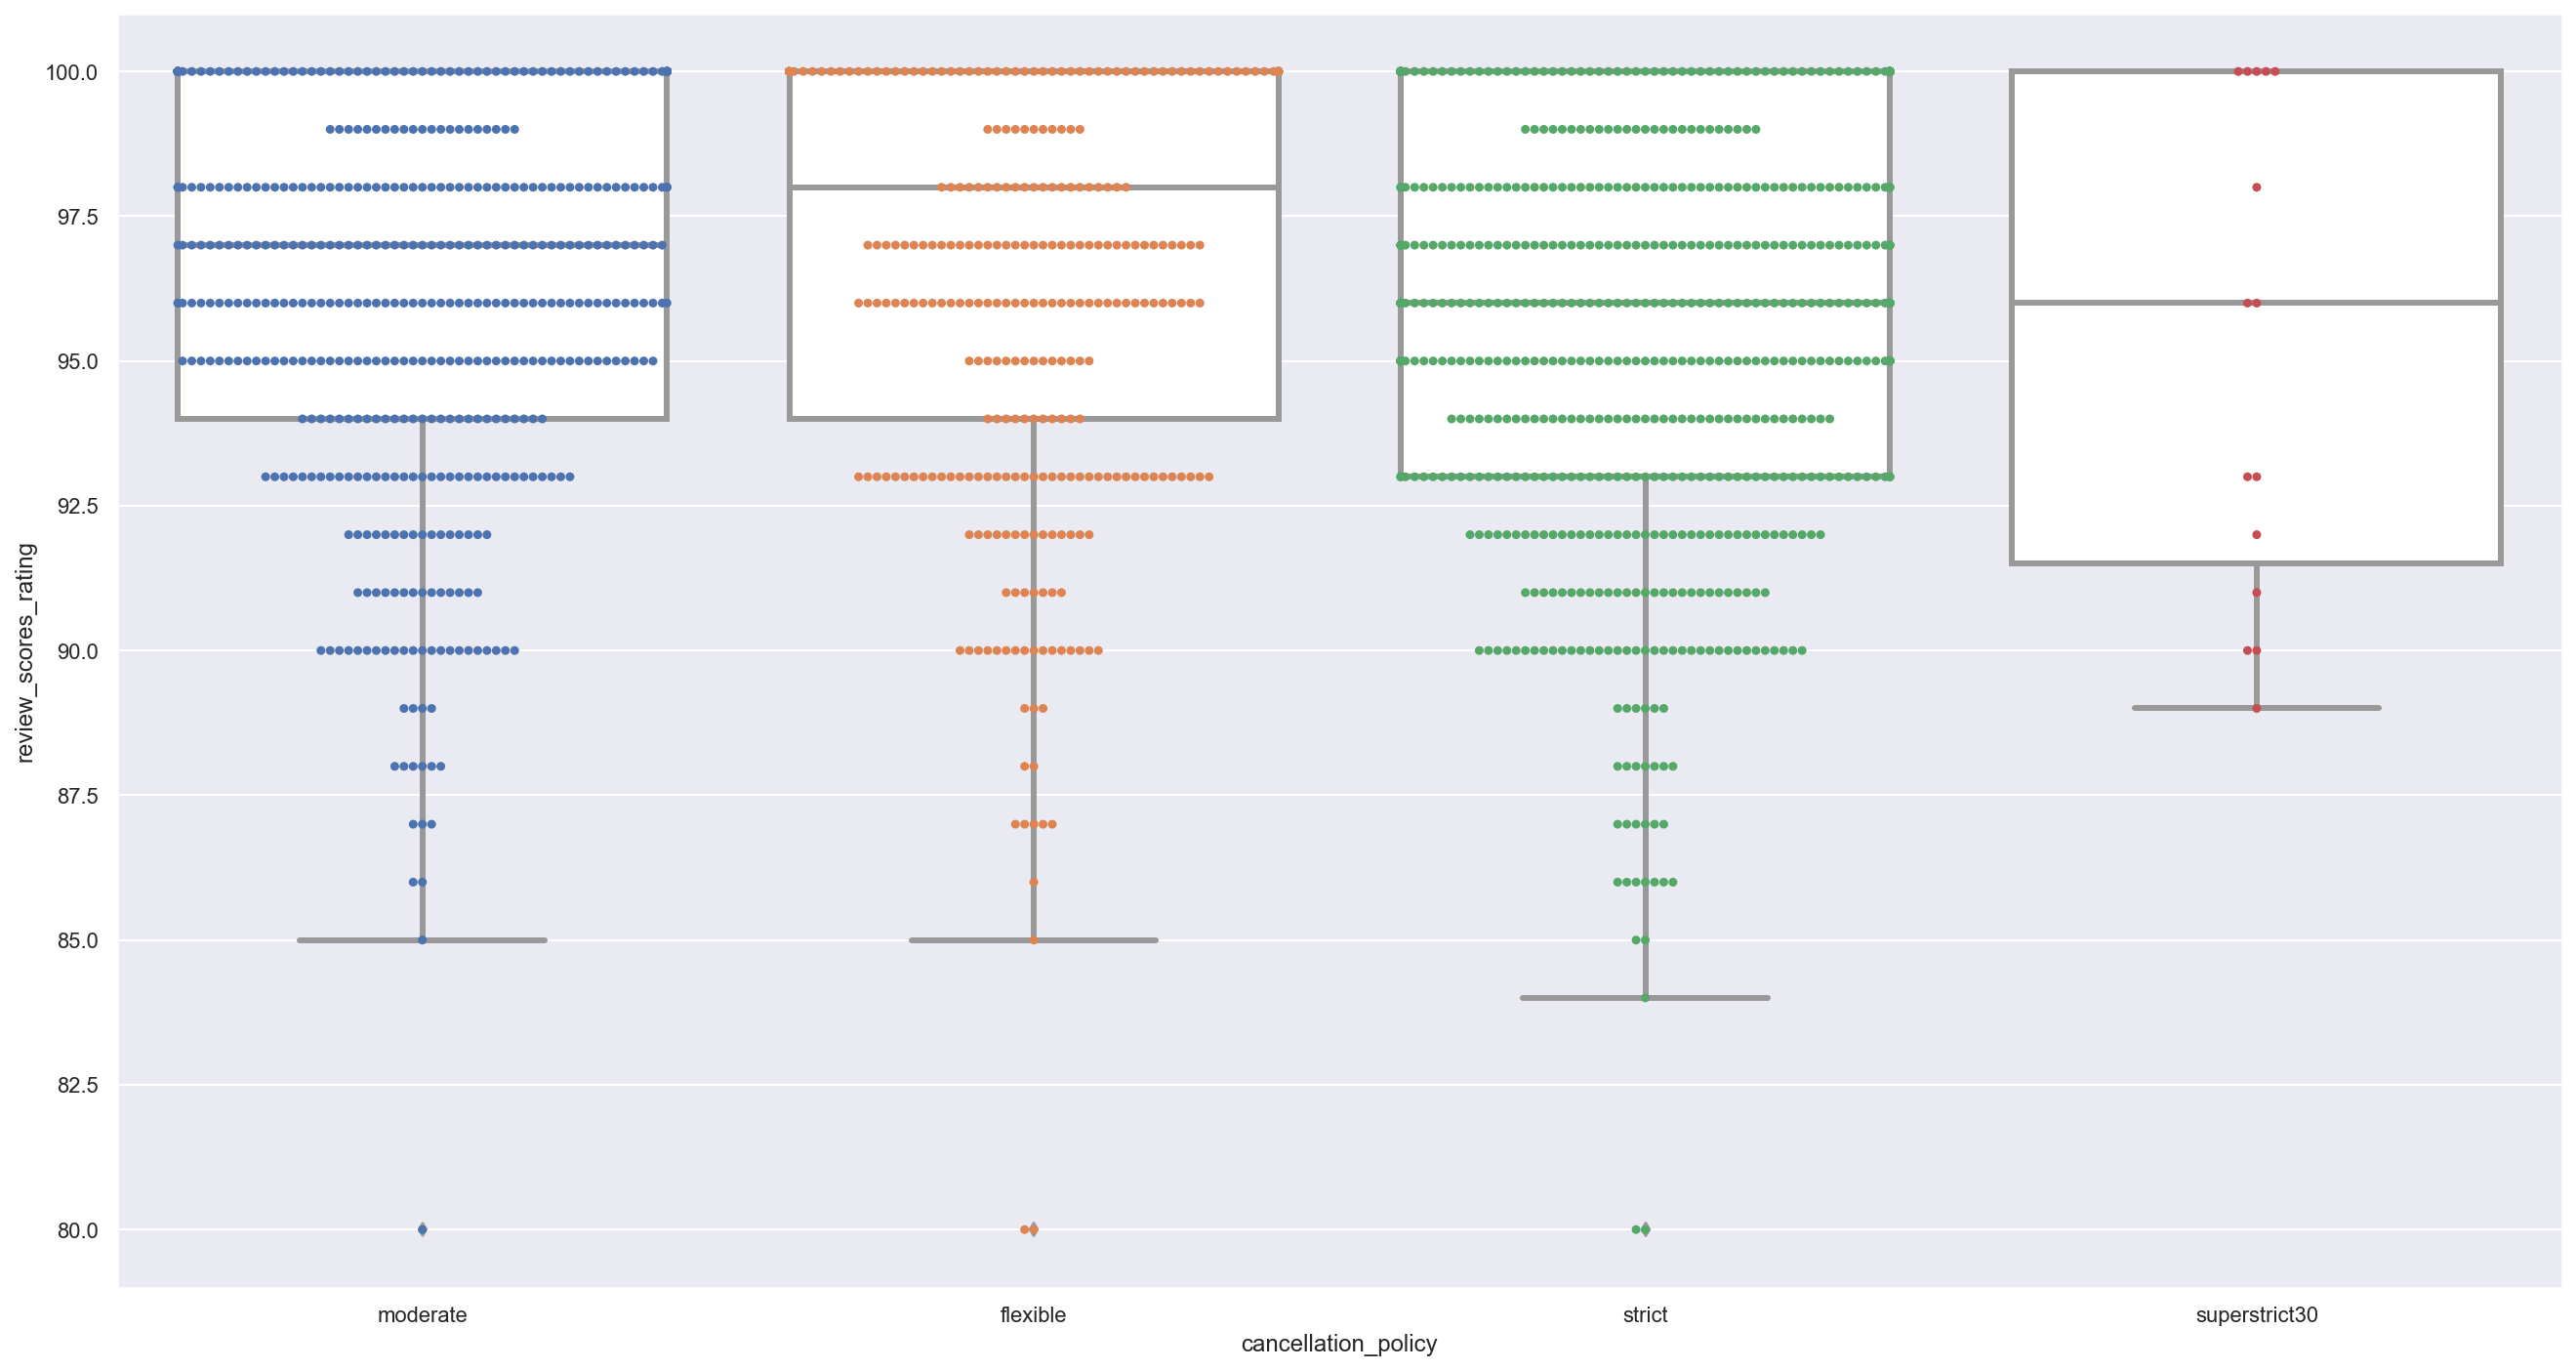

In [76]:
plot_swarmbox(filtered_features,'cancellation_policy','review_scores_rating', 20, 12)

In [77]:
model = ols('review_scores_rating ~ cancellation_policy', data=filtered_features).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
cancellation_policy,215.618119,3.0,5.506789,0.00092
Residual,21430.817482,1642.0,NaN,NaN


In [78]:
tmper_df = filtered_features[['review_scores_rating','cancellation_policy']]
df1 = tmper_df.groupby('cancellation_policy').count()
df2 = tmper_df.groupby('cancellation_policy').mean()
df1['mean'] = df2['review_scores_rating']
df1.rename(columns=({'review_scores_rating': 'count'}))

,count,mean
cancellation_policy,,
flexible,389,96.784062
moderate,503,96.268390
strict,739,95.901218
superstrict30,15,95.200000


## 4.2 host_is_superhost

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 60.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


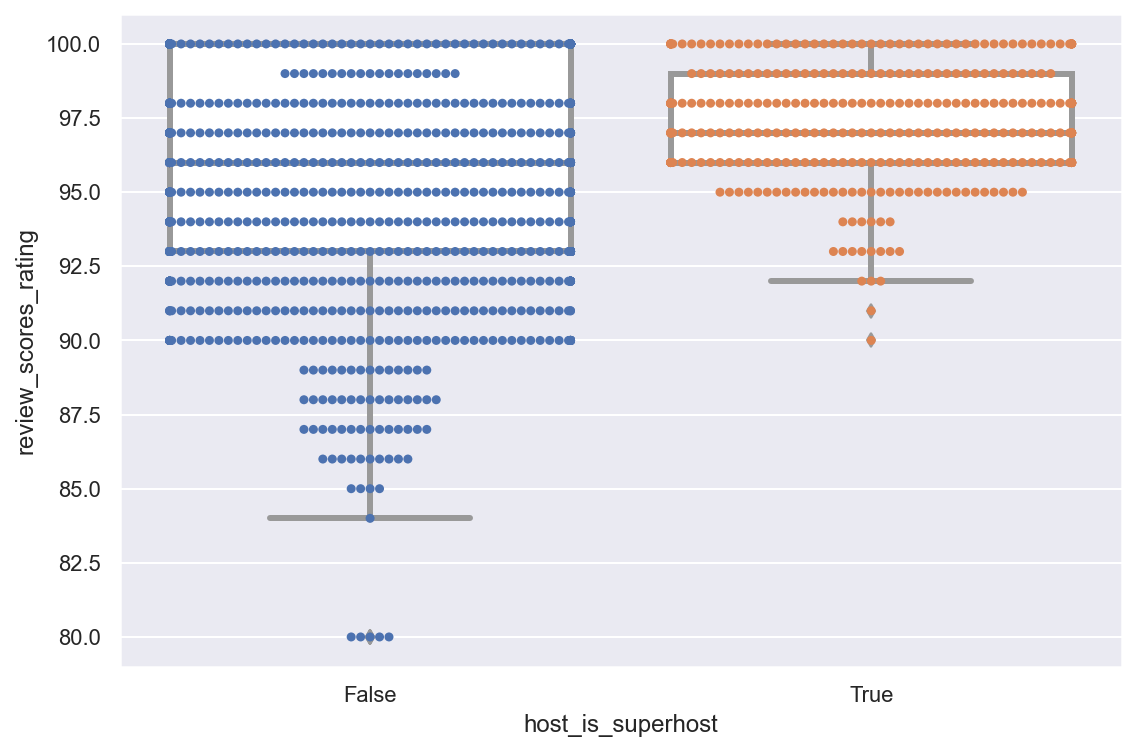

In [79]:
plot_swarmbox(filtered_features,'host_is_superhost','review_scores_rating')

In [80]:
model = ols('review_scores_rating ~ host_is_superhost', data=filtered_features).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
host_is_superhost,522.209384,1.0,40.641121,2.370379e-10
Residual,21124.226217,1644.0,NaN,NaN


In [81]:
tmper_df = filtered_features[['review_scores_rating','host_is_superhost']]
df1 = tmper_df.groupby('host_is_superhost').count()
df2 = tmper_df.groupby('host_is_superhost').mean()
df1['mean'] = df2['review_scores_rating']
df1.rename(columns=({'review_scores_rating': 'count'}))

,count,mean
host_is_superhost,,
False,1299,95.924557
True,347,97.305476


## 4.3 price

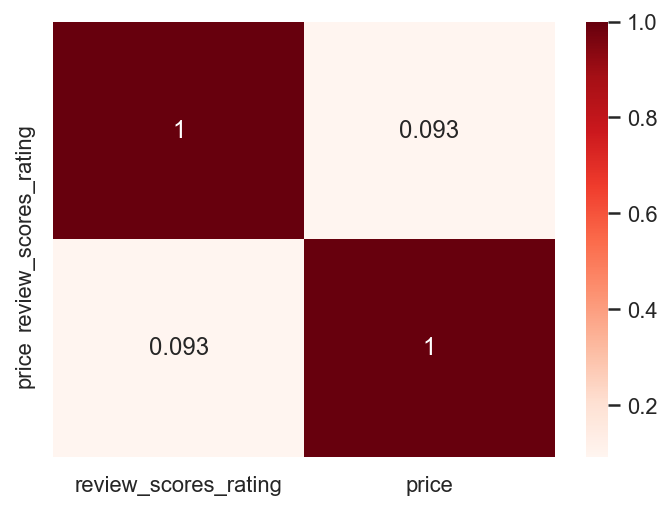

In [82]:
plot_corr(filtered_features,'review_scores_rating','price')

<AxesSubplot:xlabel='review_scores_rating', ylabel='price'>

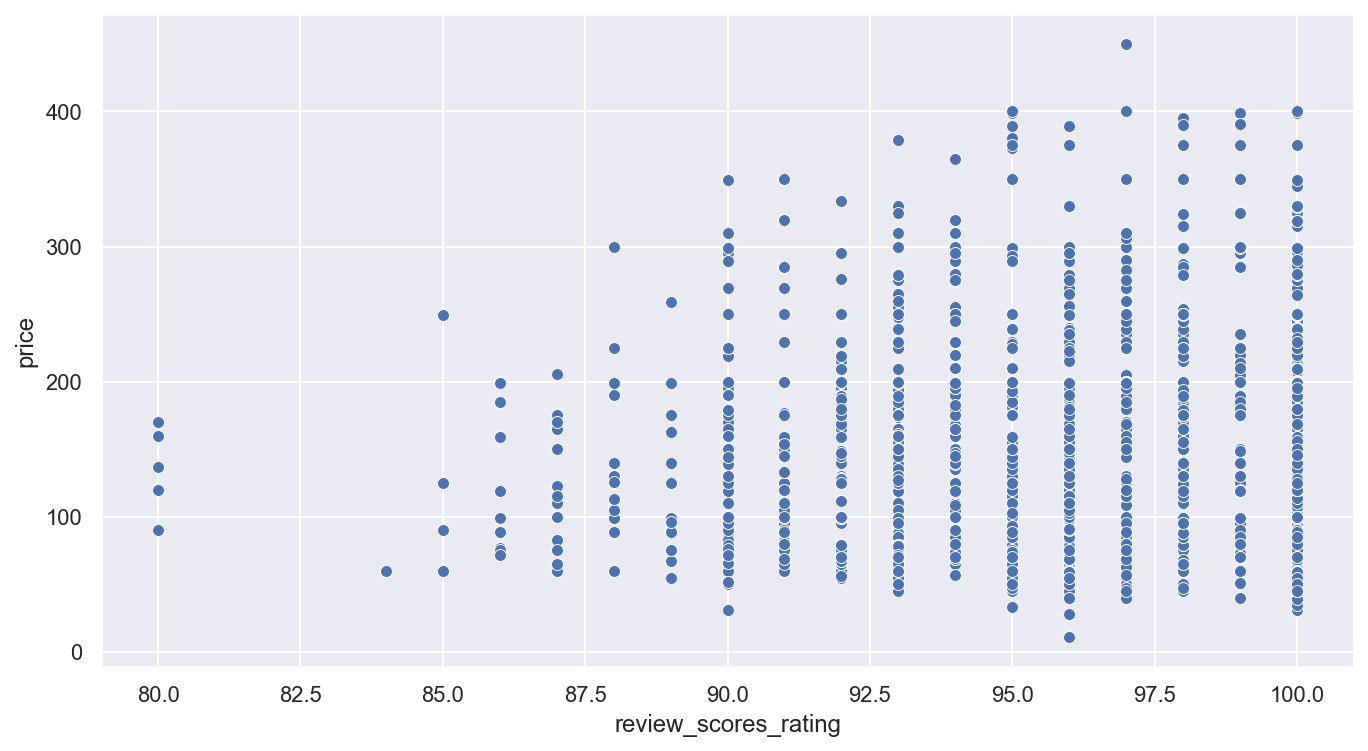

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_features, x="review_scores_rating", y="price")

## 4.4 review_scores_location

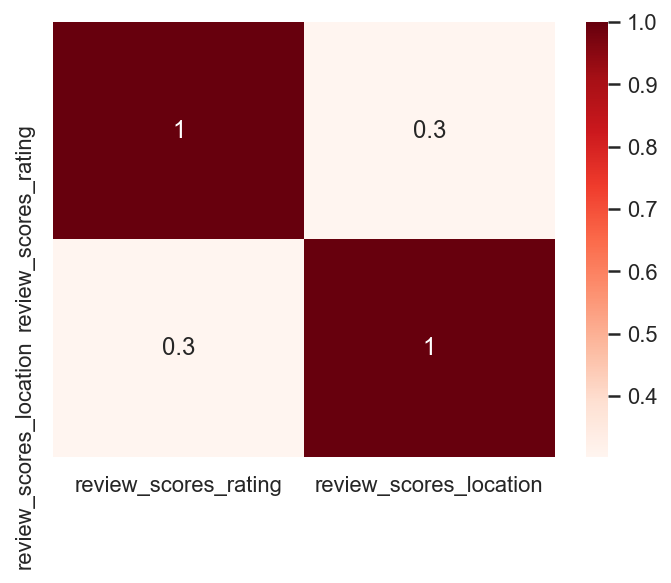

In [84]:
plot_corr(filtered_features,'review_scores_rating','review_scores_location')

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


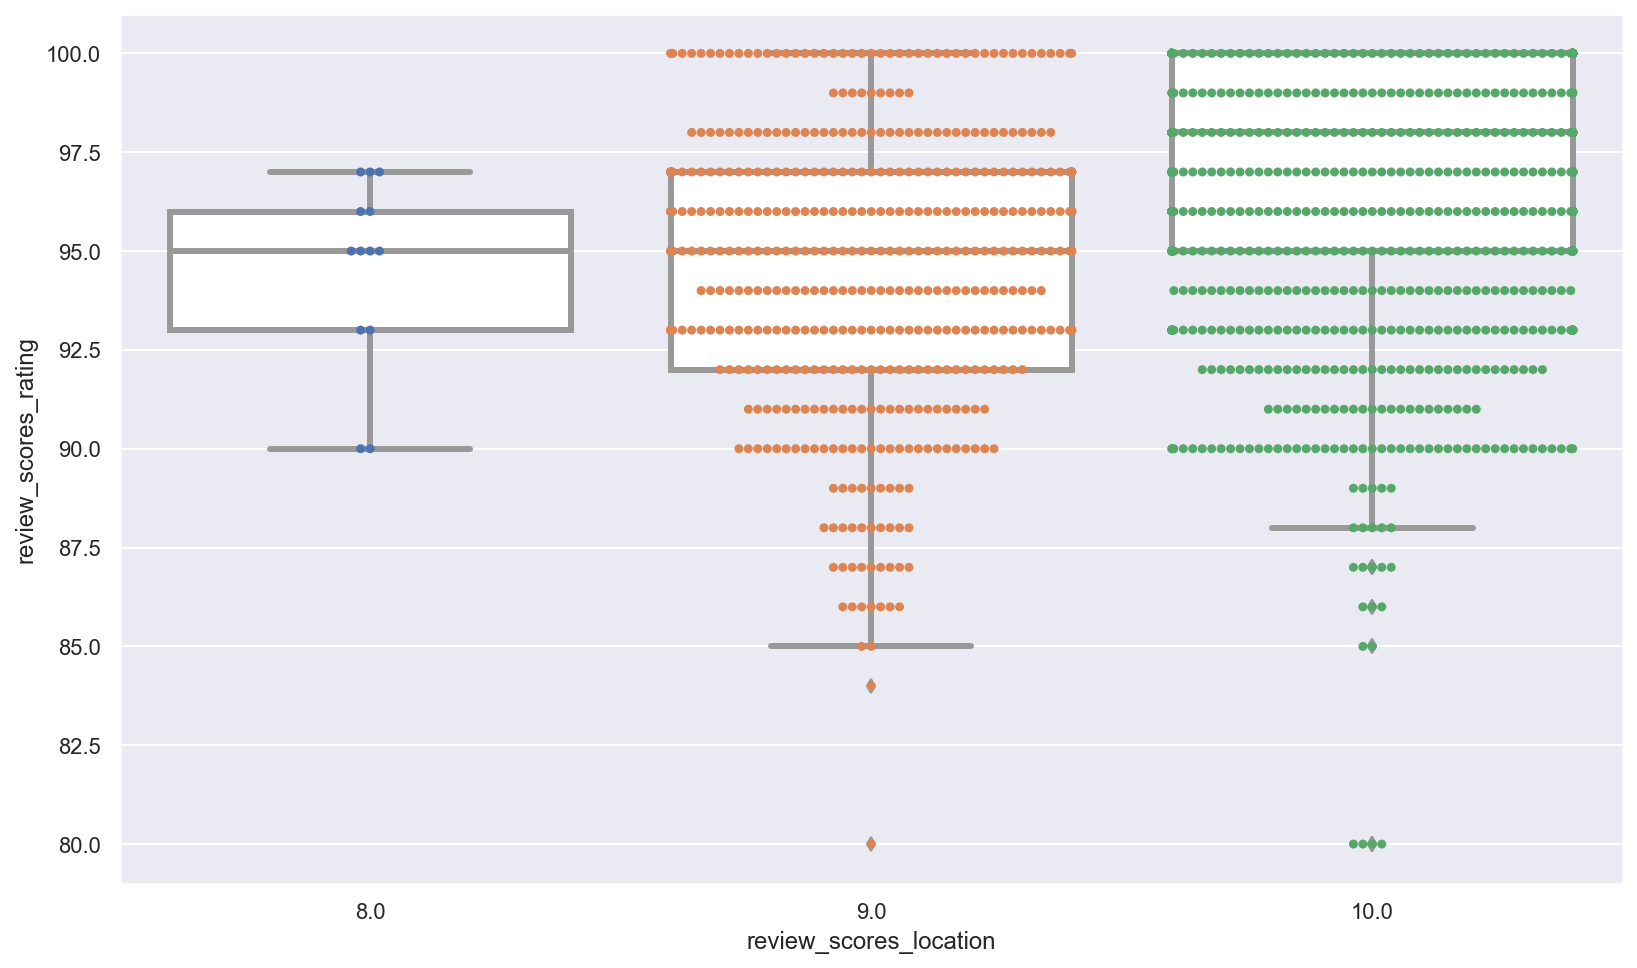

In [85]:
plot_swarmbox(filtered_features, 'review_scores_location', 'review_scores_rating', 12, 8)

In [86]:
tmper_df = filtered_features[['review_scores_rating','review_scores_location']]
df1 = tmper_df.groupby('review_scores_location').count()
df2 = tmper_df.groupby('review_scores_location').mean()
df1['mean'] = df2['review_scores_rating']
df1.rename(columns=({'review_scores_rating': 'count'}))

,count,mean
review_scores_location,,
8.0,13,94.538462
9.0,499,94.557114
10.0,1134,96.964727


## 4.5 review_scores_cleanliness

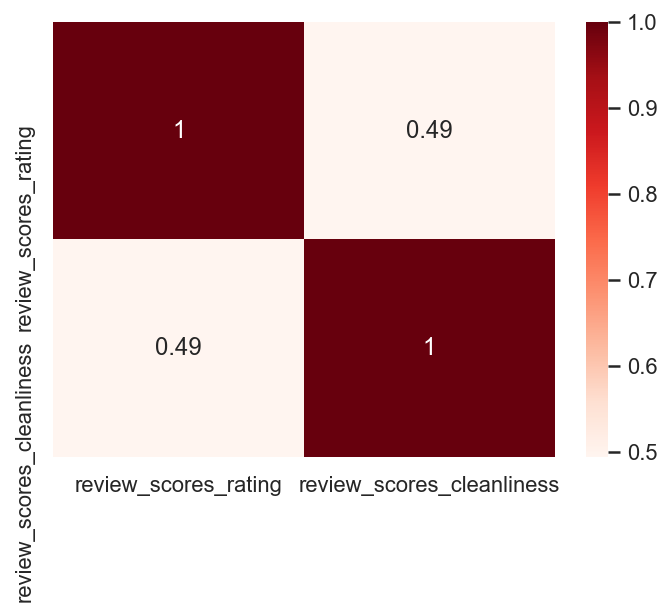

10.0    1213
9.0      396
8.0       37
Name: review_scores_cleanliness, dtype: int64

In [87]:
plot_corr(filtered_features, 'review_scores_rating','review_scores_cleanliness')
filtered_features['review_scores_cleanliness'].value_counts()

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 59.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


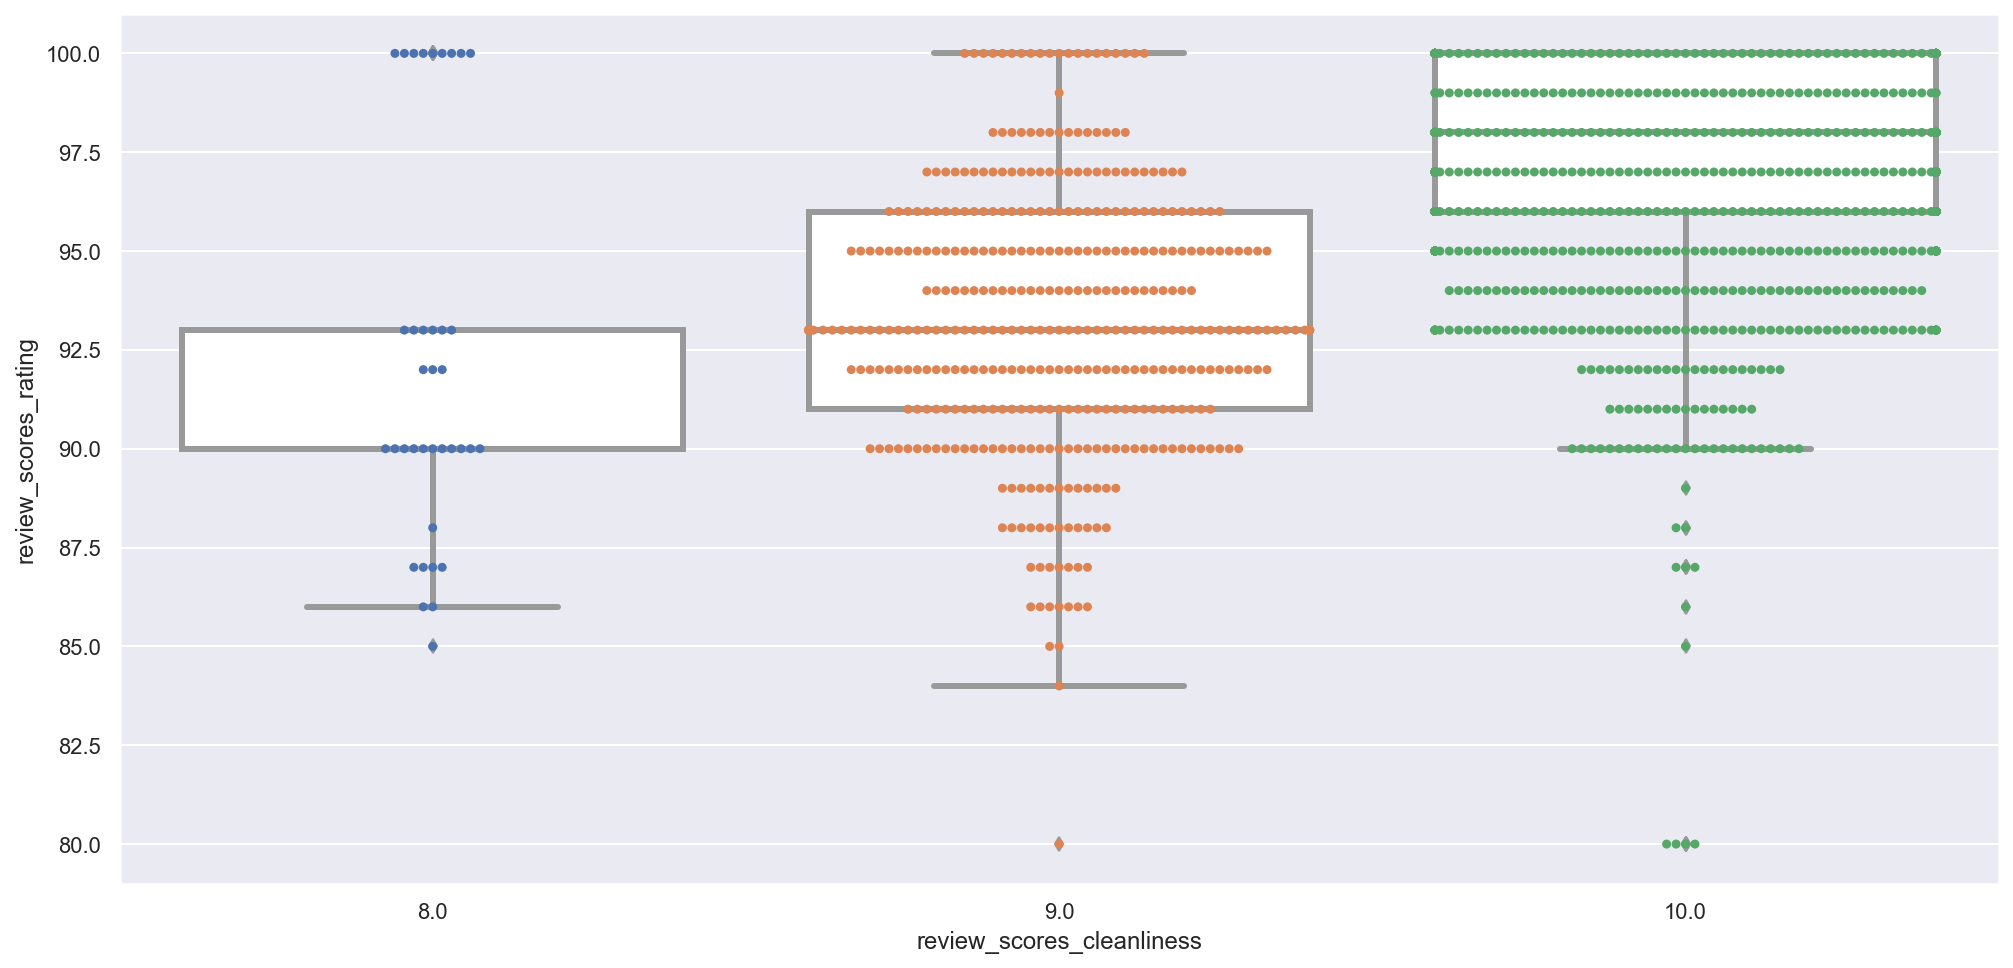

In [88]:
plot_swarmbox(filtered_features,'review_scores_cleanliness','review_scores_rating', 15, 8)

# 3rd question: Can we find negative and positive reviews based on texts?
I will predict the review score/customer statisfaction (target) to find what factors affect customer satisfaction?

# Data preparation functions

In [91]:
def categorize_rating(df, col_name, threshold=60):
    """ 
    Catergorize review scores rating
    
    Args:
    df: dataframe. The pandas dataframe.
    col_name: string. The column name that you want to categorize the values.
    threshold: int. The threshold is range between 0 and 100.
    
    Returns:
    data: The dataframe after catergorized col_name column.
    
    """
    # Set to 1 for postive and 0 for negative to match tweet dataset 
    data = df.copy() 
    data['sentiment'] = data[col_name]
    for i in range(len(data[col_name])):
        if data.loc[i, col_name] > threshold:
            data.loc[i,'sentiment'] = 1 # positive
        else:
            data.loc[i,'sentiment'] = 0 # negative 
    data.drop(col_name,axis=1, inplace=True)
    return data

def beautisoup(text):
    """ 
    Remove lxml format by beautifulsoup library 
    
    Args:
    text: string. the text that wants to remove lxml format.
    
    Returns:
    bom_removed: The text after removed The Browser Object Model (bom) or lxml
    
    """
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    return bom_removed

def tokenize(text):
    """ 
    Tokenize and lemmatize words in a string (text)
    
    Args:
    text: string. The string that wants to do word tokenization.
    
    Returns:
    clean_tokens: The text after tokenized and lemmatized.
    
    """
    # Perform word tokenization and Lemmatization
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    # Cleaning each token (word)
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
        

    return clean_tokens

# Optimize model function

In [92]:
def optimize_sentiment_model(pipeline):
    """ 
    Search for the best model parameters of the pipeline by using grid-search cross-validation
    
    Args:
    pipeline: object. The pipeline object.
    
    Returns:
    cv: The model that includes best model parameters.
    
    """
    # Specify GridSearchCV hyperparameters
    parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text_pipeline__vect__max_df': (0.5, 0.75),
        'features__text_pipeline__vect__max_features': (None, 5000),
        'features__text_pipeline__tfidf__use_idf': (True, False),
        'clf__n_estimators': [100, 200],
        'clf__min_samples_split': [2, 3],
        'clf__random_state': [42]
    }
    
    # Perform GridSearchCV
    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=2, n_jobs = -1, cv = 3)
    
    return cv

# Load datasets

## Airbnb Boston and Seattle comment datasets

In [93]:
cols = ['listing_id','comments']
# Load data then convert missing value to NaN type
boston_reviews = pd.read_csv("datasets/boston/reviews.csv", usecols=cols, na_values = missing_values)
seattle_reviews = pd.read_csv("datasets/seattle/reviews.csv", usecols=cols, na_values = missing_values)
    
# Fetch the desired columns
boston_rating = raw_boston_data[['id','review_scores_rating']]
seattle_rating = raw_seattle_data[['id','review_scores_rating']]
    
# Merge two columns with two keys (id and listing id)
boston_merged_comments = pd.merge(boston_rating, boston_reviews, 
                                      left_on='id', right_on='listing_id', how='left').drop('listing_id', axis=1)
seattle_merged_comments = pd.merge(seattle_rating, seattle_reviews, 
                                      left_on='id', right_on='listing_id', how='left').drop('listing_id', axis=1)
    
# Concatenate boston and seattle rows
merged_comments = pd.concat([boston_merged_comments, seattle_merged_comments], axis=0, join='outer', 
                                ignore_index=True, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
    
# Drop missing values then reset the df index
merged_comments = merged_comments.dropna()
merged_comments.reset_index(inplace=True,drop=True)

## Tweet dataset

In [94]:
# Change tweet columns name; To make columns easier to read
cols = ['sentiment','id','date','query_string','user','text']
tweet_df = pd.read_csv("datasets/training.1600000.processed.noemoticon.csv",
                            header=None, names=cols, encoding="ISO-8859-1", na_values = missing_values)
    
# Select the positive and negative tweet data in equal ratio (negative = 0, positive = 4).
neg_tweets = tweet_df[0:10000]
pos_tweets = tweet_df[800000:810000]
    
# Concatenate the negative and postive tweets
merged_tweets = pd.concat([neg_tweets, pos_tweets], axis=0, join='outer', ignore_index=True, keys=None,
                          levels=None, names=None, verify_integrity=False, copy=True)

In [115]:
tweet_df

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Global variables

In [95]:
# Cleaning regex
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' # URL
spl_regex = '(@[A-Za-z0-9_]+)' # Special Characters
www_pat = r'www.[^ ]+' # www URL

# 1. Data preparation
- Begin the data preparation or data cleansing

## 1.1 Clean the lxml by beautifulsoup

In [96]:
# Remove lxml format by beautifulsoup library
clean_tweet_texts = []
# Show beautifulsoup progress
for i in range(merged_tweets.shape[0]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, merged_tweets.shape[0] ))                                                                    
    clean_tweet_texts.append(beautisoup(merged_tweets['text'][i]))

cleaned_tweets = pd.DataFrame(clean_tweet_texts,columns=['text'])
cleaned_tweets['target'] = merged_tweets.sentiment

Tweets 10000 of 20000 has been processed
Tweets 20000 of 20000 has been processed


## 1.2 Filter special characters

In [97]:
for i, tweet in enumerate(cleaned_tweets['text']):
    # Filter URL www.
    cleaned_tweets.loc[i,'text'] = re.sub(www_pat, '', cleaned_tweets.loc[i,'text'])

    # Filter URL
    detected_urls = re.findall(url_regex, cleaned_tweets.loc[i,'text'])
    for url in detected_urls:
        cleaned_tweets.loc[i,'text'] = cleaned_tweets.loc[i,'text'].replace(url, "urlplaceholder")

    # Filter special characters
    detected_spl = re.findall(spl_regex, cleaned_tweets.loc[i,'text'])
    for spl in detected_spl:
        cleaned_tweets.loc[i,'text'] = cleaned_tweets.loc[i,'text'].replace(spl, "")  

## 1.3 Categorize review scores rating
- The threshold is range between 0 and 100. according to the review_scores_rating.
- 1 is postive sentiment and 0 is negative sentiment.

In [98]:
# Catergorize comments (review score rating)
cleaned_comments = categorize_rating(merged_comments, 'review_scores_rating', threshold=60)

In [99]:
# Catergorize tweets (target)
cleaned_tweets['sentiment'] = cleaned_tweets['target'].map({4: 1, 0:0})
cleaned_tweets.drop('target', axis=1, inplace=True)

## Note that:
Tweets dataset are included in the dataset because I use tweet data to help predict the sensation of the texts due to the high bias of the Airbnb reviews variables as follow:

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

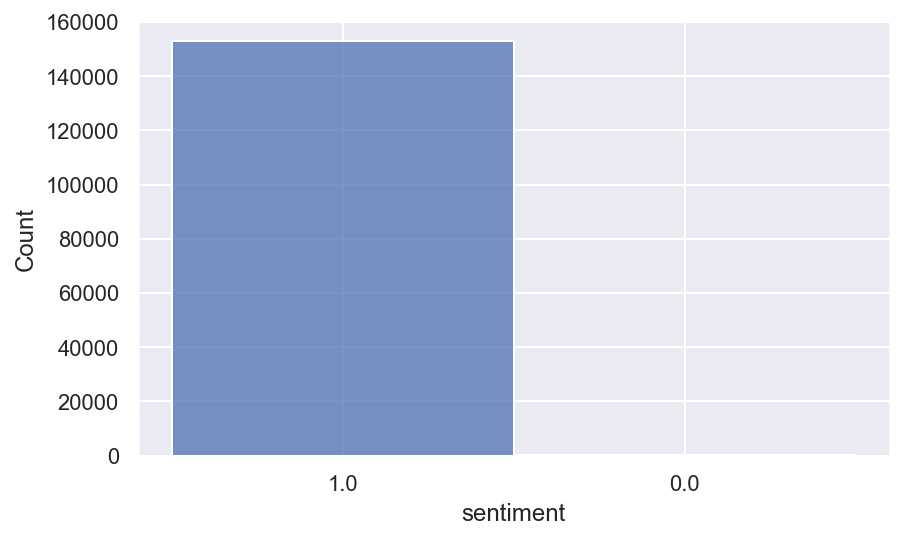

In [100]:
sns.histplot(cleaned_comments['sentiment'].astype(str))

In [101]:
cleaned_comments['sentiment'].value_counts()

1.0    152796
0.0       172
Name: sentiment, dtype: int64

### From the figure above, the Airbnb reviews do not provide sufficient data to classify the negative side of reviews. 
### Therefore, I use the tweets dataset to help classify the negative reviews.

## 1.4 Check the cleaned datasets

### Airbnb dataset

In [102]:
cleaned_comments.head()

,id,comments,sentiment
0,3075044,Andrea is a great host. Neighborhood is wonder...,1.0
1,3075044,We had a great time at Andrea's place. He is v...,1.0
2,3075044,Adrea was very welcoming and flexible to our n...,1.0
3,3075044,Andrea made us feel welcome because he made th...,1.0
4,3075044,Me and my friend were so happy about Andrea's ...,1.0


### Tweet dataset

In [103]:
cleaned_tweets.head()

,text,sentiment
0,"urlplaceholder - Awww, that's a bummer. You ...",0
1,is upset that he can't update his Facebook by ...,0
2,I dived many times for the ball. Managed to s...,0
3,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all. i'm mad. why am...",0


# 2. Split data to training and testing datasets
### I use Tweet dataset as training dataset. Boston and Seattle as testing set.

## 2.1 Training: Declare x and y for tweet dataset

In [104]:
# Define X (features)
X_train = cleaned_tweets.drop('sentiment',axis=1).values

# Reshape X, To be able to put in model
if X_train.shape[1] > 0:
    X_train = X_train.reshape((X_train.shape[0],))
    
# Define y (target)
y_train = cleaned_tweets['sentiment'].values

## 2.2 Testing: Declare x and y for boston and seattle dataset

In [105]:
# Define X (features)
X_test = cleaned_comments.drop(['sentiment','id'],axis=1).values

# Reshape X, To be able to put in model
if X_test.shape[1] > 0:
    X_test = X_test.reshape((X_test.shape[0],))
    
# Define y (target)
y_test = cleaned_comments['sentiment'].values

# 3. Build a model
- By using a pipeline.

## Pipeline 

### 3.1 CountVectorizer
- 1.Tokenize - Break a document into a bag of words.
- 2.Lemmatizing each word. For example, make the word in the basic form ex. looking -> look.
- 3.Represent each word by assigning a number. To make the words be able to use in machine learning.

### 3.2 Tfidf
- Reduce the effect of the common word in a particular document by divide frequency of the word.

### 3.3 Put the data to the Random Forest Classifier to classify the sentiment of each review.

In [106]:
# The data pipeline for create a model
pipeline = Pipeline([
    ('features', FeatureUnion([ # Concatenates results of multiple transformer objects. 
            
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ]))
    ])),
    
    ('clf', RandomForestClassifier())
])

## 3.3 Build and train Random Forest model for classifier the review scores rating (comments)

In [107]:
# Build and optimize sentiment model by gridsearch and cross-validation
sentiment_model = optimize_sentiment_model(pipeline)
sentiment_model.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 19.1min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x7fd970c87d30>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())]))])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__min_samples_split': [2, 3],
                         'clf__n_estimators': [100, 200],
                         'clf__random_state': [42],
                         'features__text_pipeline__tfidf__use_idf': (True,
                             

 ### 3.3.1 Model best parameters

In [108]:
sentiment_model.best_params_

{'clf__min_samples_split': 3,
 'clf__n_estimators': 200,
 'clf__random_state': 42,
 'features__text_pipeline__tfidf__use_idf': False,
 'features__text_pipeline__vect__max_df': 0.5,
 'features__text_pipeline__vect__max_features': None,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

# 4. Predict on boston and seattle dataset
- The accuracy of model can be increased by increasing the size of the training set

In [109]:
# Apply model to comment dataset to see it's positive or negative comments
y_pred = sentiment_model.predict(X_test)

# Display accuracy in percentage
average_accuracy = (y_pred == y_test).mean()
print("Average accuracy:", average_accuracy*100)

Average accuracy: 74.10700277182156


### 4.1 Confusion matrix 

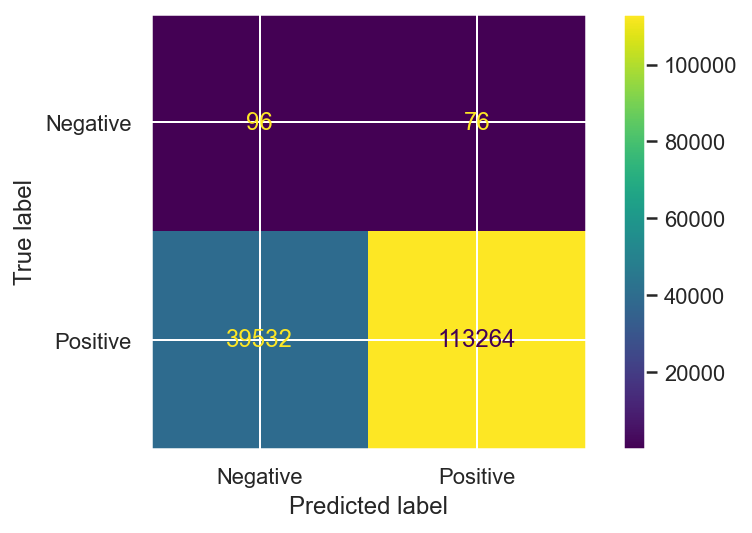

In [110]:
# Plot confusion matrix 
plot_confusion_matrix(sentiment_model,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Negative','Positive'])

### The positive sentiment that is correctly predicted

In [111]:
(113264/(39532+113264))*100

74.12759496321894

### The negative sentiment that is correctly predicted

In [112]:
96/(76+96)*100

55.81395348837209